In [10]:
import torch
from utils import convert_mesh_container_to_torch_mesh
from dataloaders.mesh_container import MeshContainer

In [11]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("No GPU available, falling back to CPU.")

hw = 128
H = hw
W = hw
num_images_per_prompt = 1
tolerance = 0.004
random_seed = 42
use_normal_map = True

No GPU available, falling back to CPU.


In [12]:
import os

def load_mesh_by_index(folder, index):
    # Get all files in the folder
    files = sorted(os.listdir(folder))
    
    # Filter only the files you want (e.g., by extension)
    valid_extensions = {".obj", ".off"}
    files = [f for f in files if os.path.splitext(f)[1].lower() in valid_extensions]
    
    # Check if the index is valid
    if index < 0 or index >= len(files):
        raise IndexError(f"Index out of range. Valid range: 0-{len(files) - 1}")
    
    # Get the corresponding file
    file_to_load = files[index]
    
    # Construct the full file path
    file_path = os.path.join(folder, file_to_load)
    print(f"Loading file: {file_path}")
    
    # Load the mesh
    mesh = MeshContainer().load_from_file(file_path)
    return mesh

# Example usage in Jupyter Notebook
folder = "meshes"
index = 2

try:
    source_mesh = load_mesh_by_index(folder, index)
except IndexError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")


Loading file: meshes/cow.obj


In [13]:
from diff3f import VERTEX_GPU_LIMIT, batch_render
import random

num_views = 100

mesh = convert_mesh_container_to_torch_mesh(source_mesh, device=device, is_tosca=False)
mesh_vertices = mesh.verts_list()[0]

if mesh_vertices is None:
    mesh_vertices = mesh.verts_list()[0]

if len(mesh_vertices) > VERTEX_GPU_LIMIT:
    samples = random.sample(range(len(mesh_vertices)), 10000)
    maximal_distance = torch.cdist(mesh_vertices[samples], mesh_vertices[samples]).max()
else:
    maximal_distance = torch.cdist(mesh_vertices, mesh_vertices).max()  # .cpu()


ball_drop_radius = maximal_distance * tolerance #TODO: check if this is needed


""" batched_renderings, normal_batched_renderings, camera, depth = batch_render(
    device=device, 
    mesh=mesh, 
    num_views=num_views, 
    H=H, 
    W=W, 
    use_normal_map=use_normal_map, 
    fixed_angle= {'type': 'elevation', 'value': 0}
) """

batched_renderings_elev, normal_batched_renderings_elev, camera_elev, depth_elev = batch_render(
    device=device, 
    mesh=mesh, 
    num_views=num_views, 
    H=H, 
    W=W, 
    use_normal_map=use_normal_map, 
    fixed_angle= {'type': 'azimuth', 'value': 0}
)



Starting batch_render with num_views=100, H=128, W=128
Fixed angle settings: {'type': 'azimuth', 'value': 0}
Rendering completed successfully


In [14]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_rotation_sequence(renderings, num_views, save_video=False):
    # Move to CPU and convert to NumPy
    renderings = renderings.cpu().numpy()
    
    if save_video:
        import cv2
        # Ensure the directory exists
        output_path = 'rotation_video.mp4'
        fourcc = cv2.VideoWriter_fourcc(*'mp4v')
        out = cv2.VideoWriter(output_path, fourcc, 30.0, (W, H))
    
    # Visualize each frame
    for i in range(num_views):
        view = renderings[i]
        
        if save_video:
            # Convert to BGR for OpenCV
            frame = (view * 255).astype(np.uint8)
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            out.write(frame)
        
        # Display every 10th frame to check progression
        if i % 1 == 0:
            plt.figure(figsize=(8, 8))
            plt.imshow(view)
            plt.title(f"Elevation: {(i/num_views)*360:.1f}°")
            plt.axis("off")
            plt.show()
            plt.close()

    if save_video:
        out.release()
        print(f"Video saved to {output_path}")

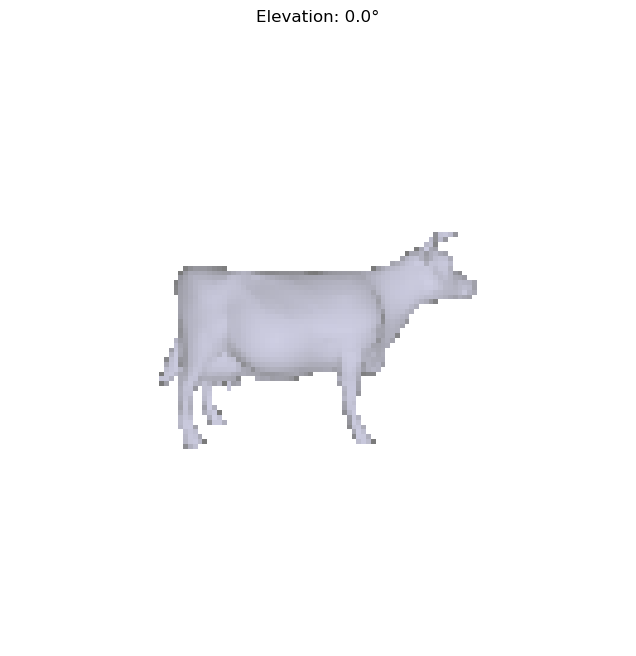

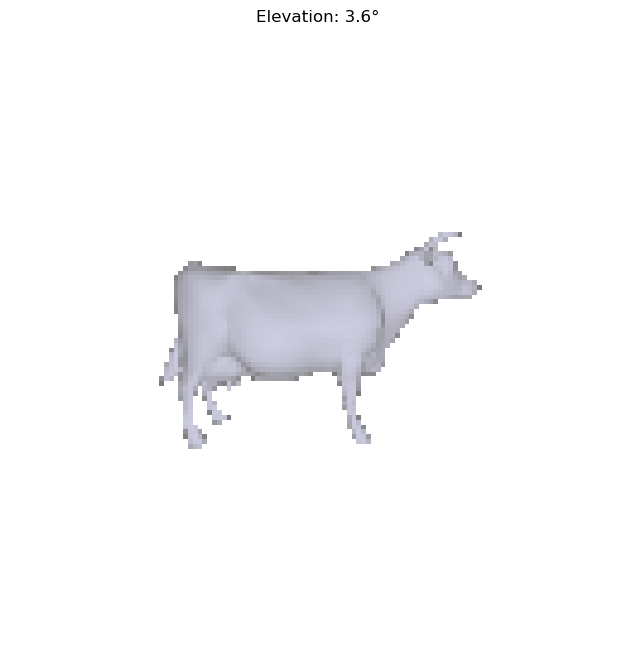

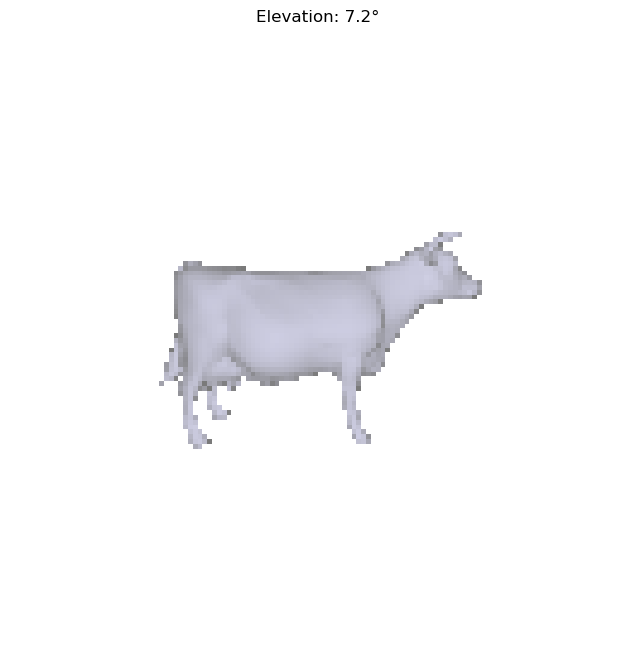

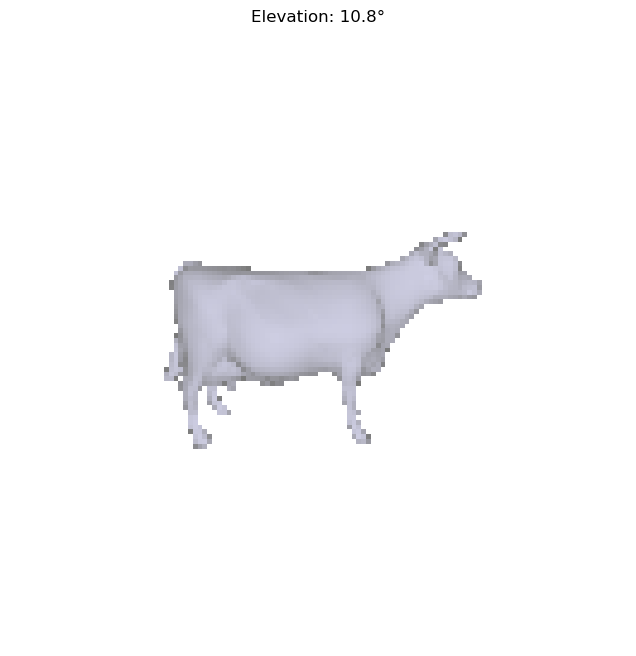

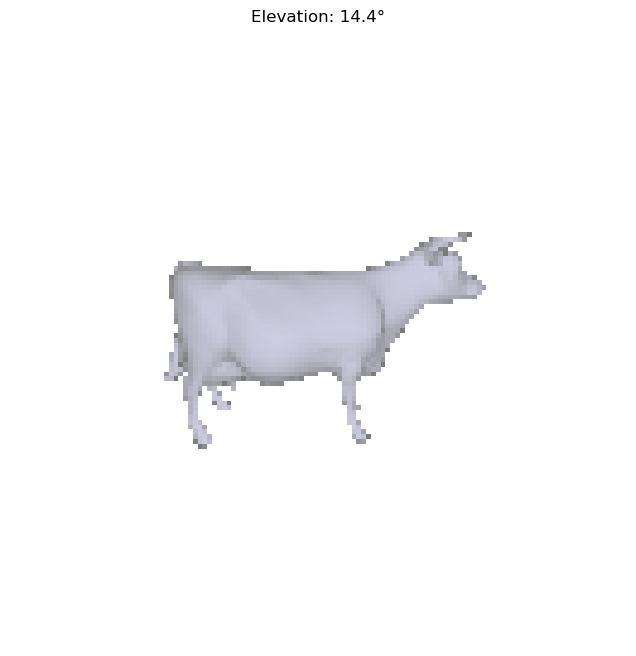

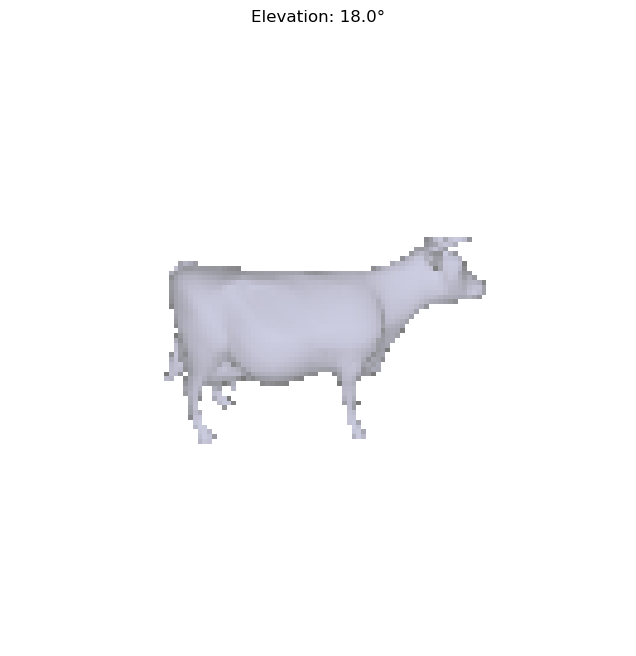

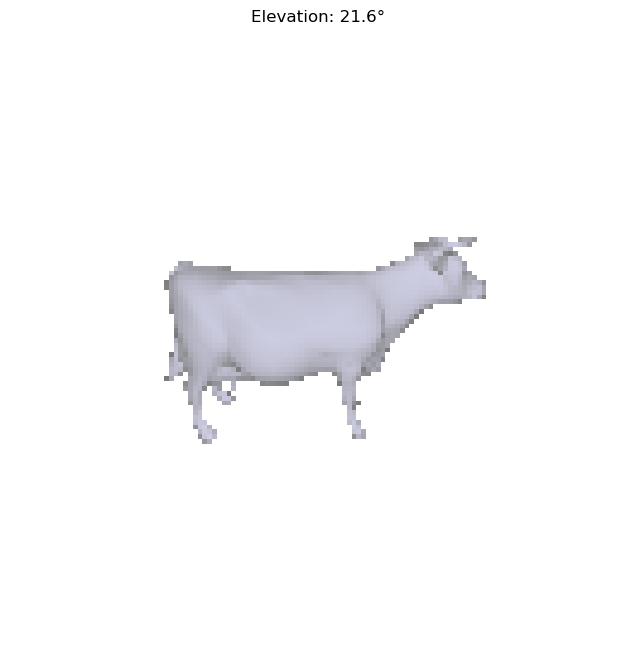

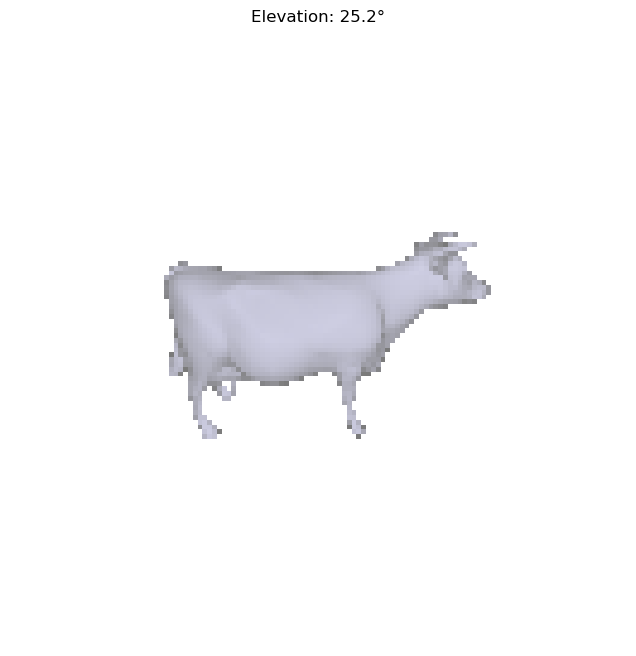

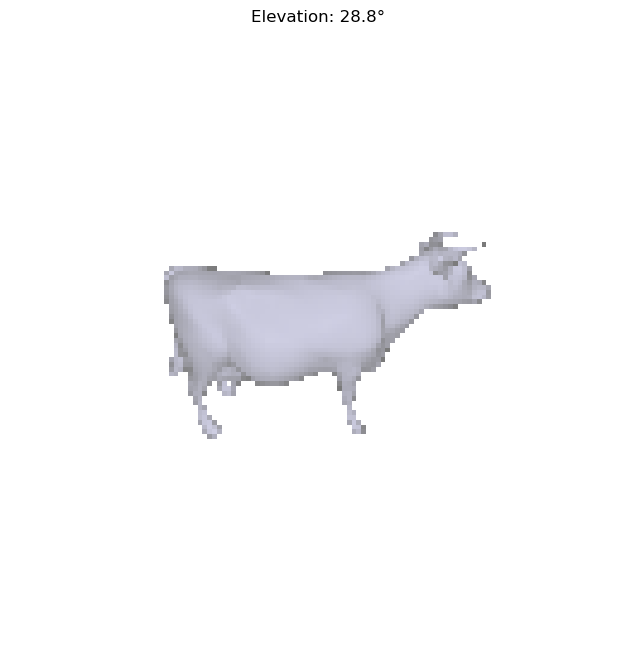

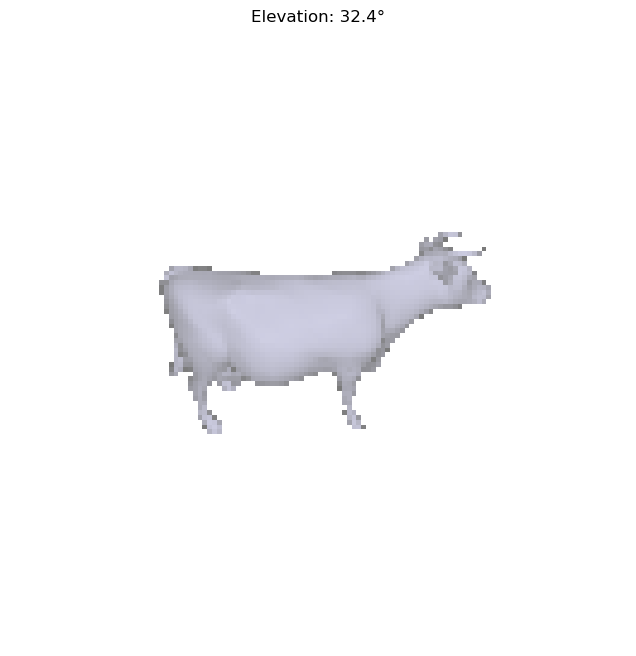

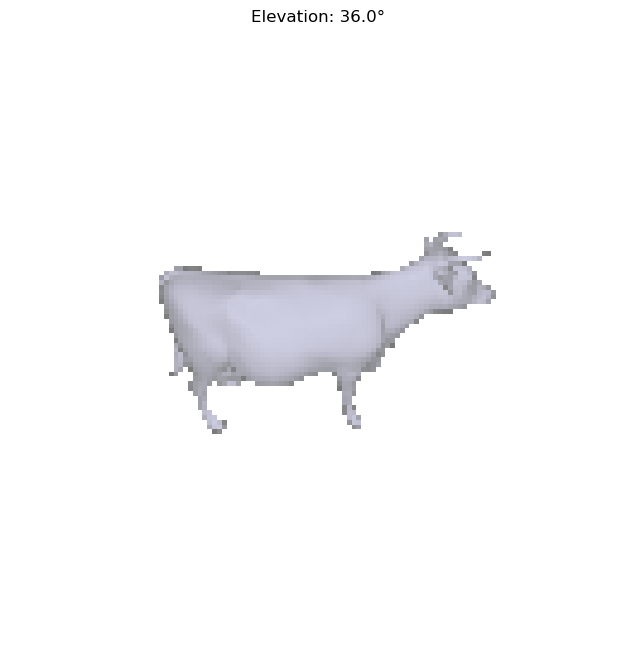

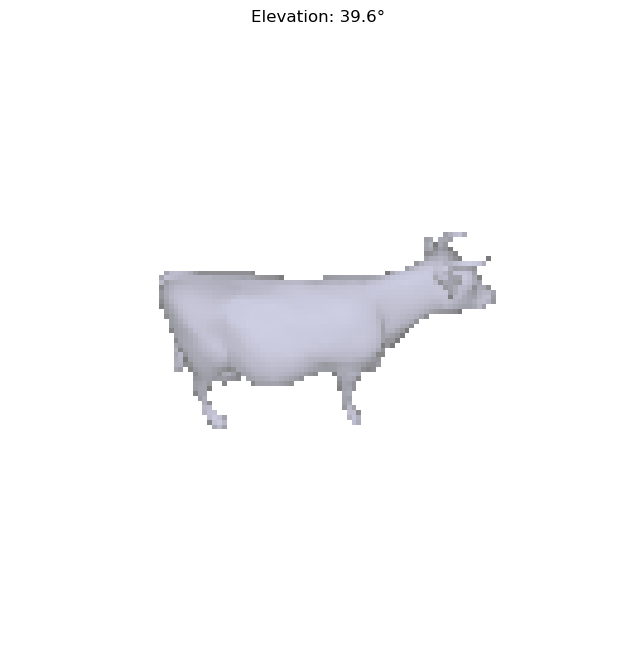

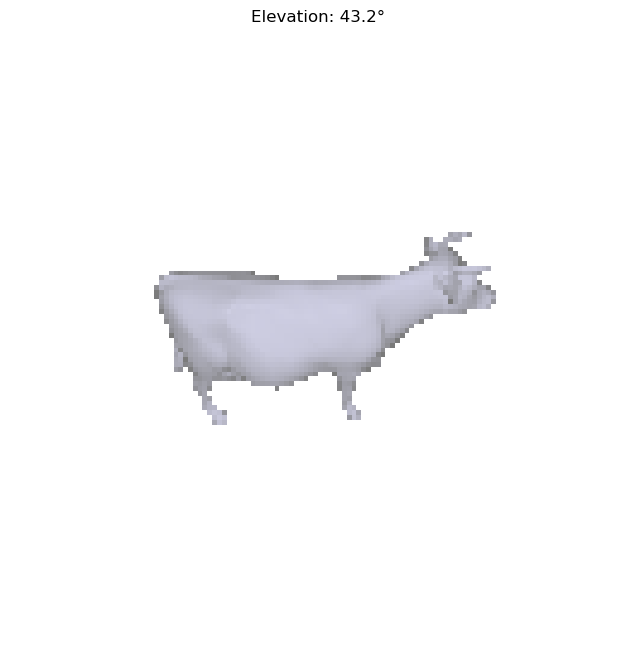

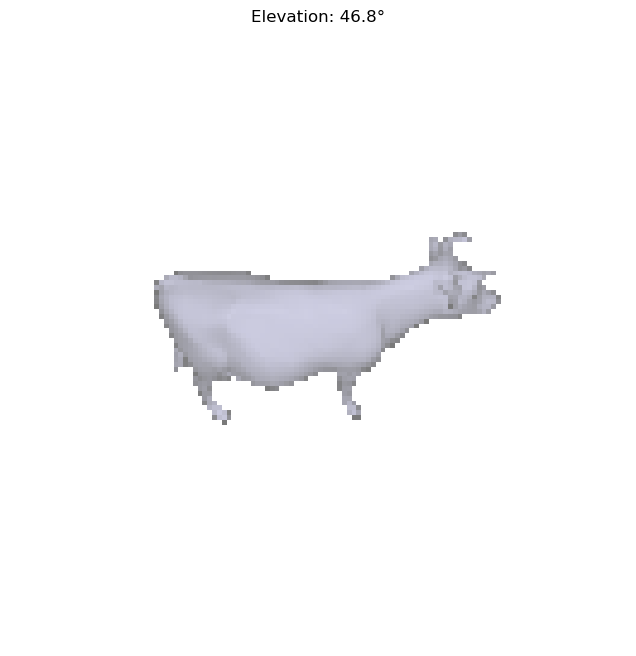

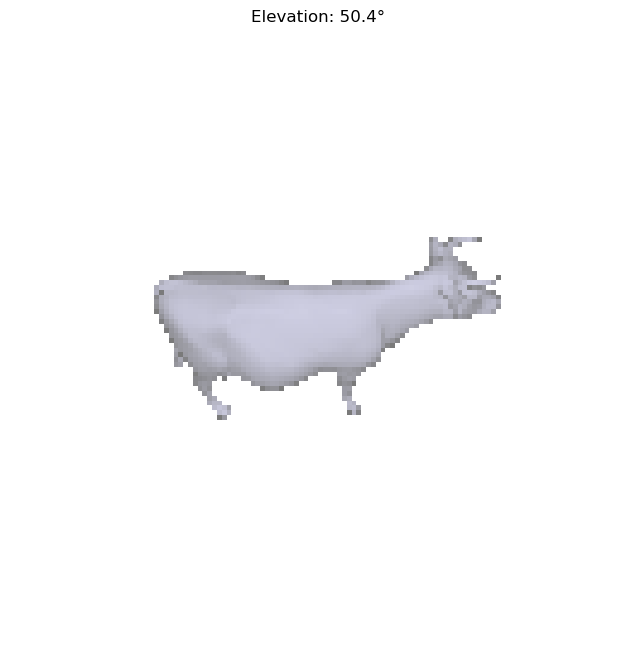

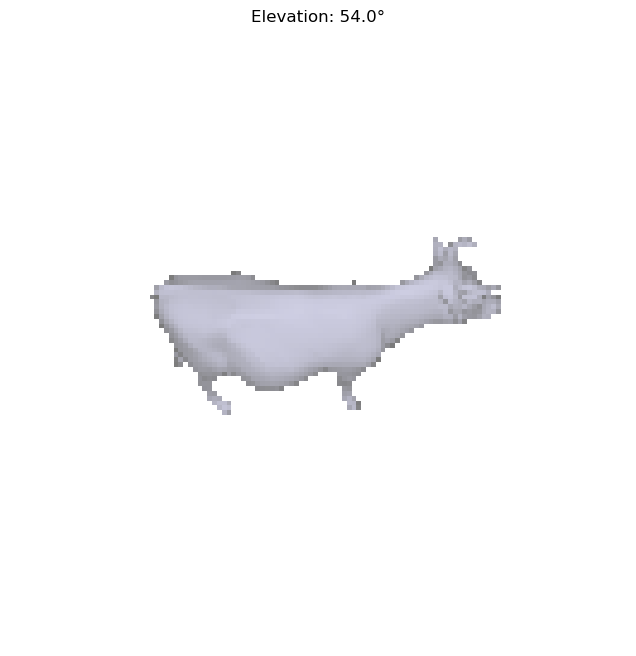

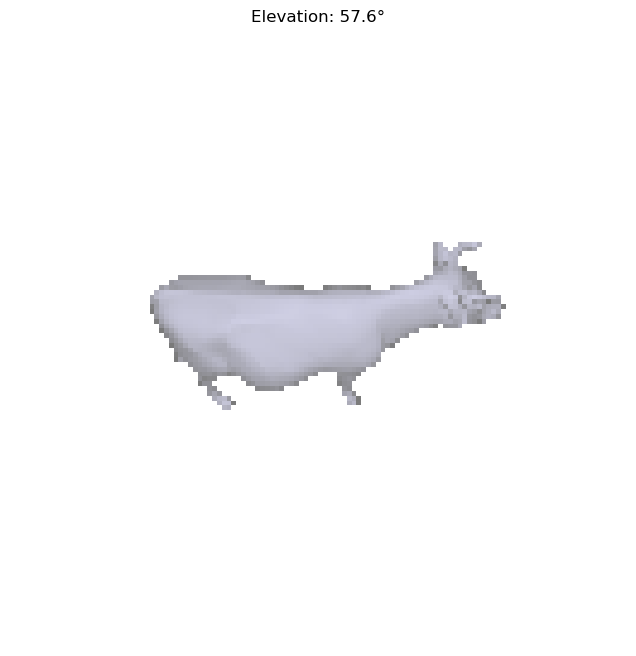

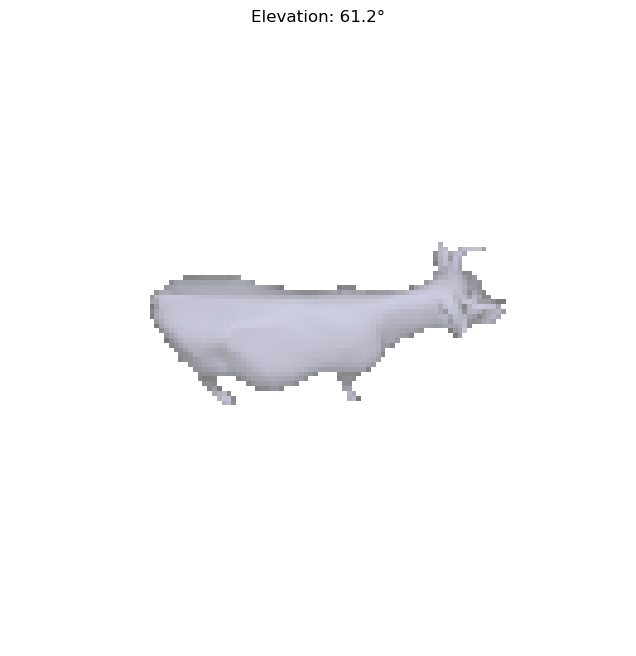

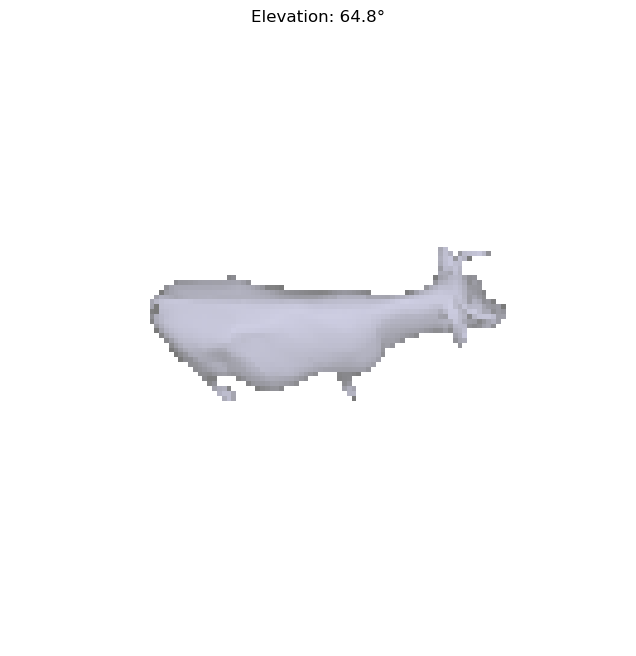

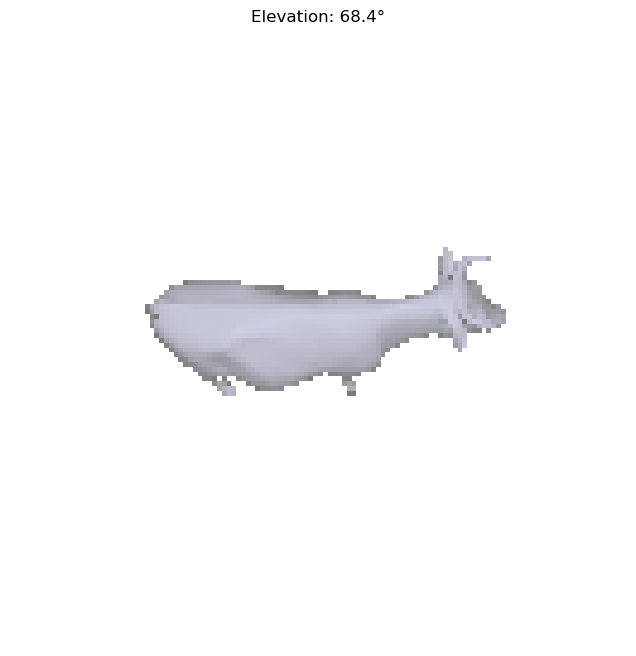

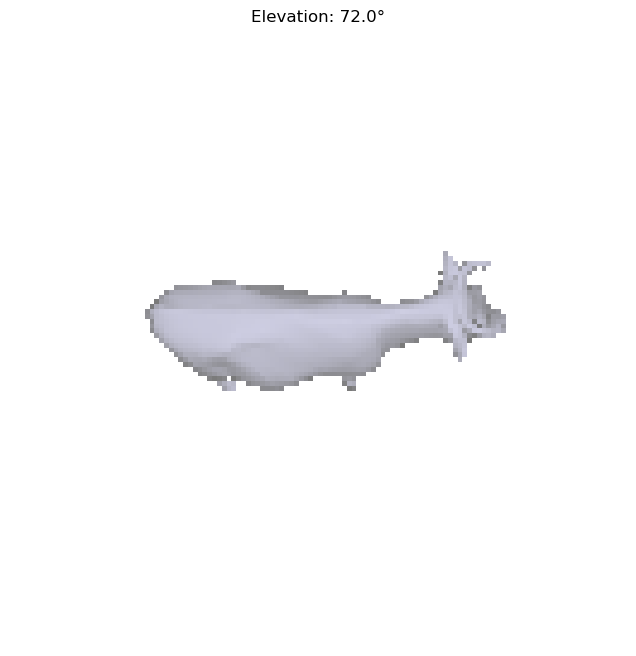

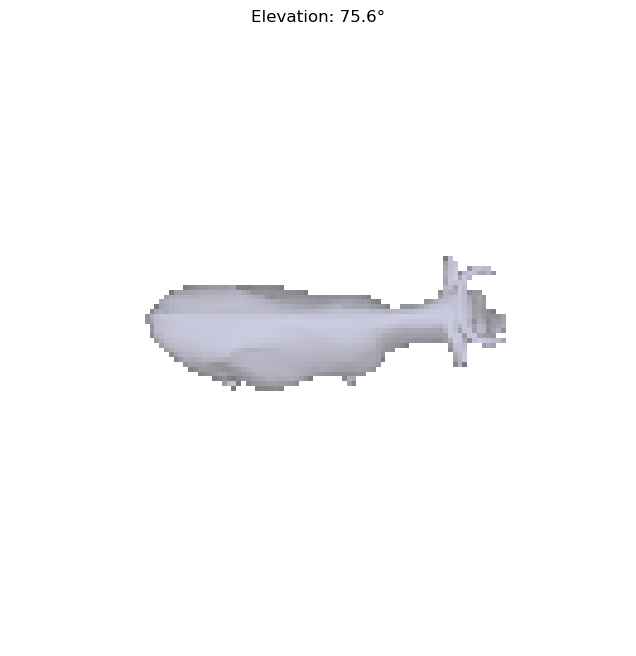

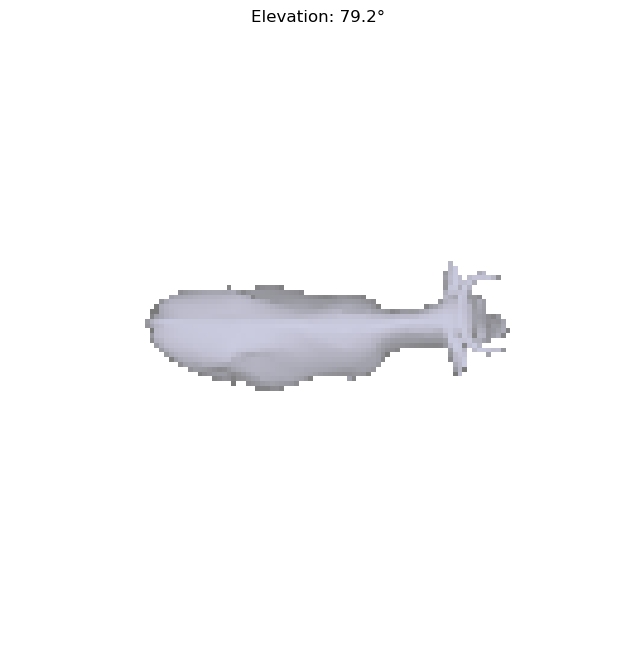

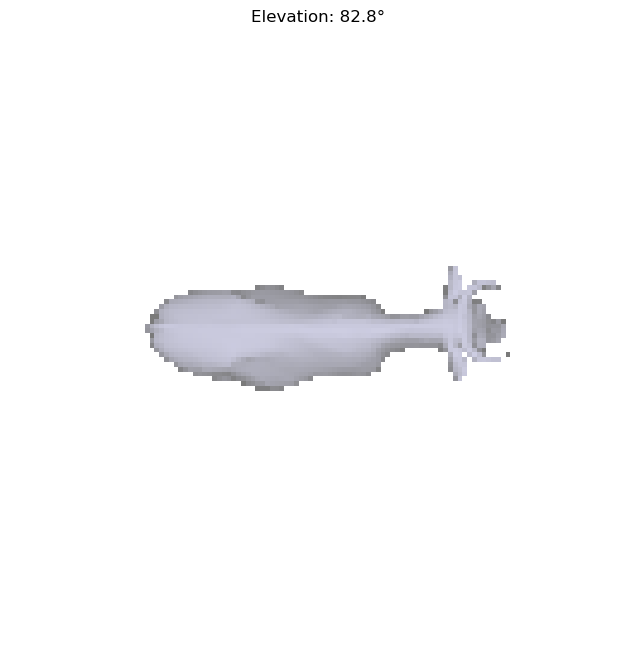

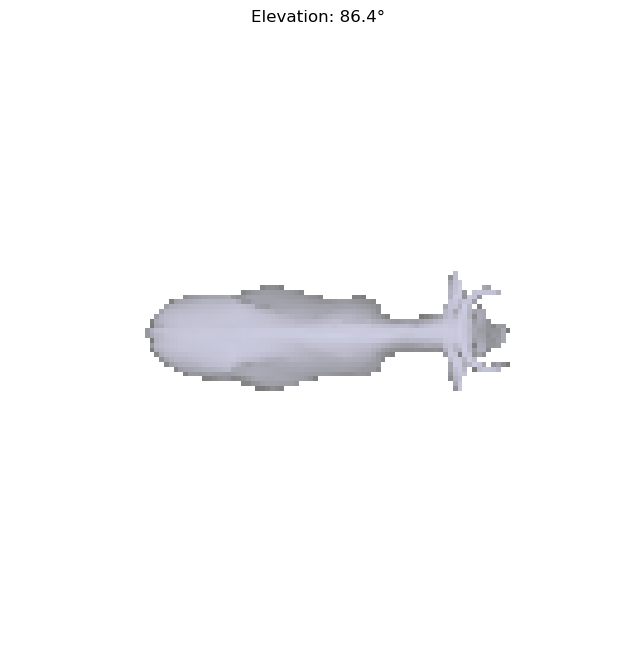

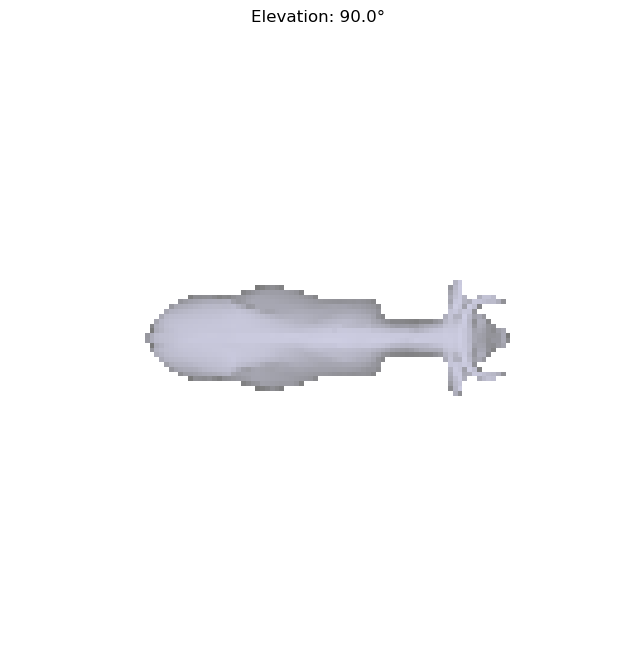

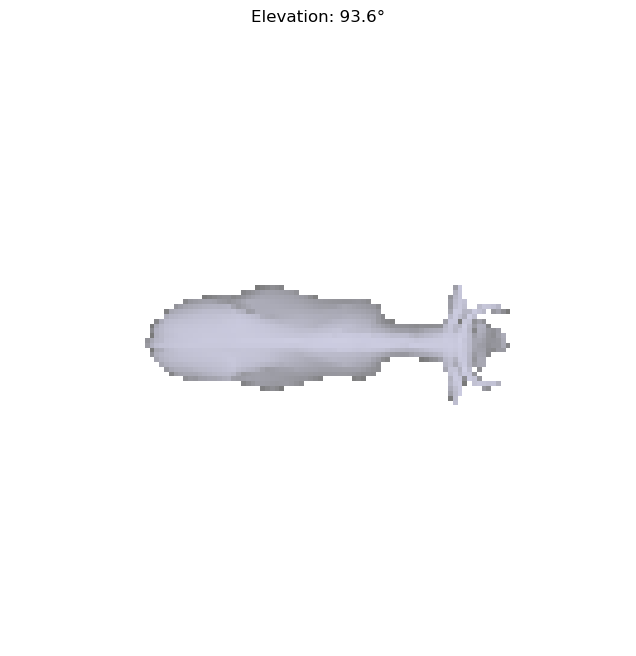

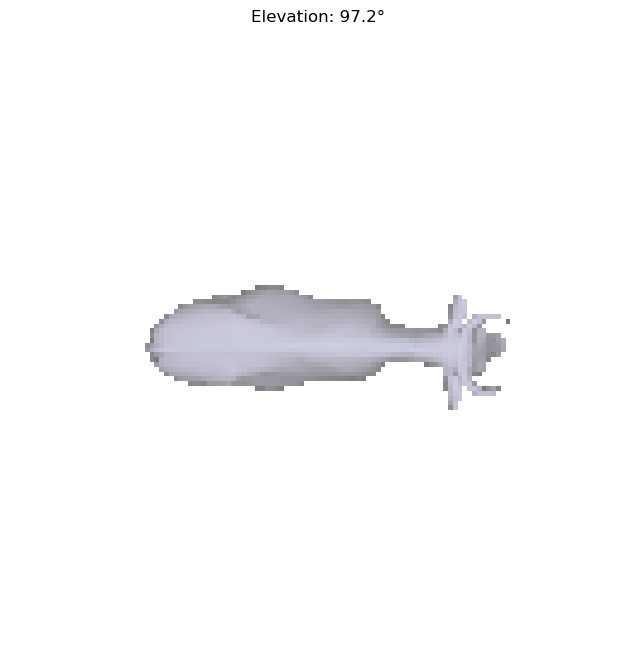

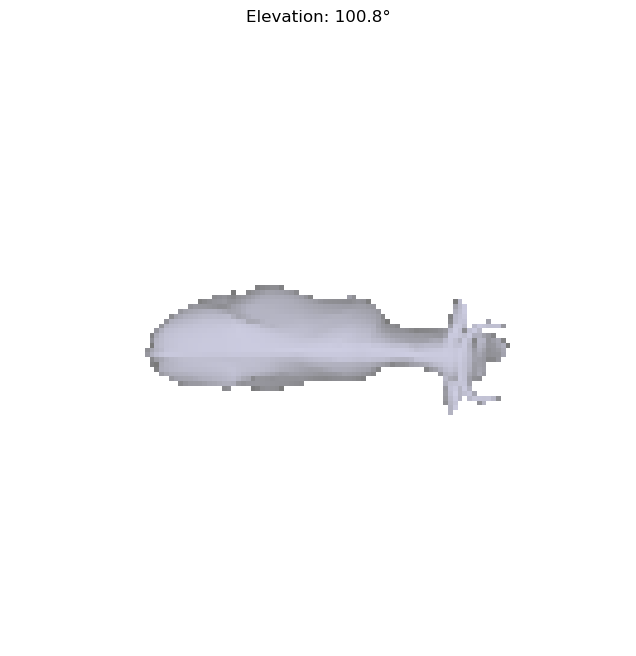

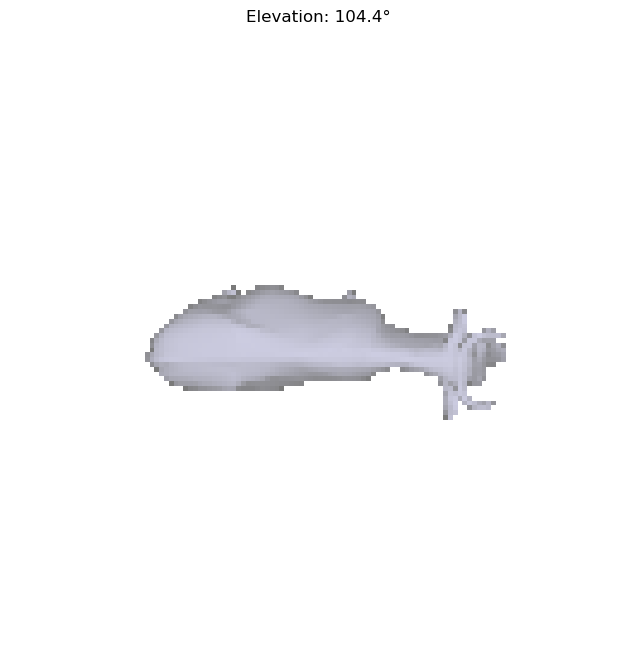

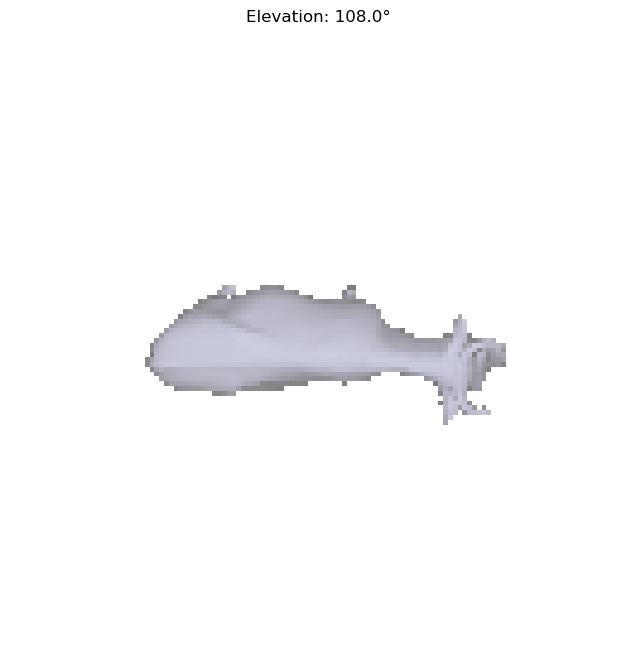

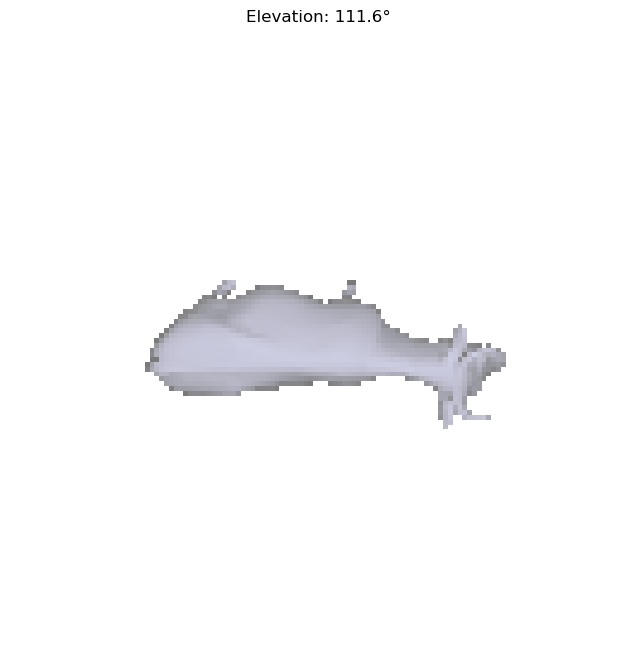

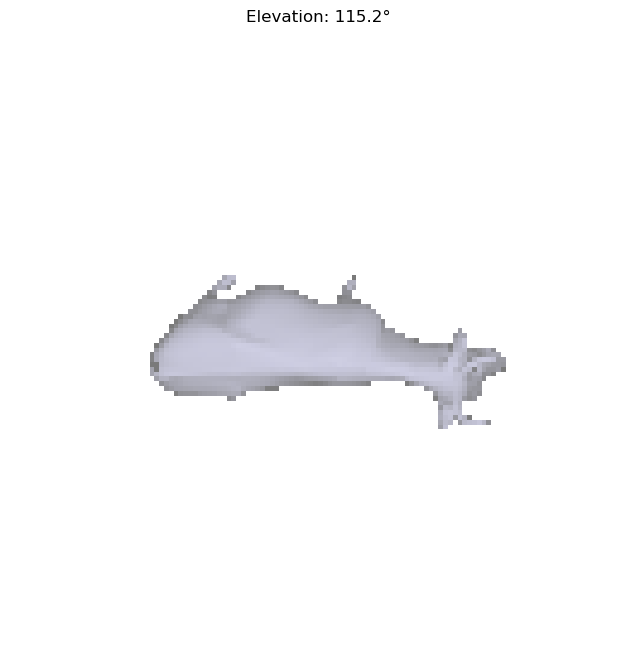

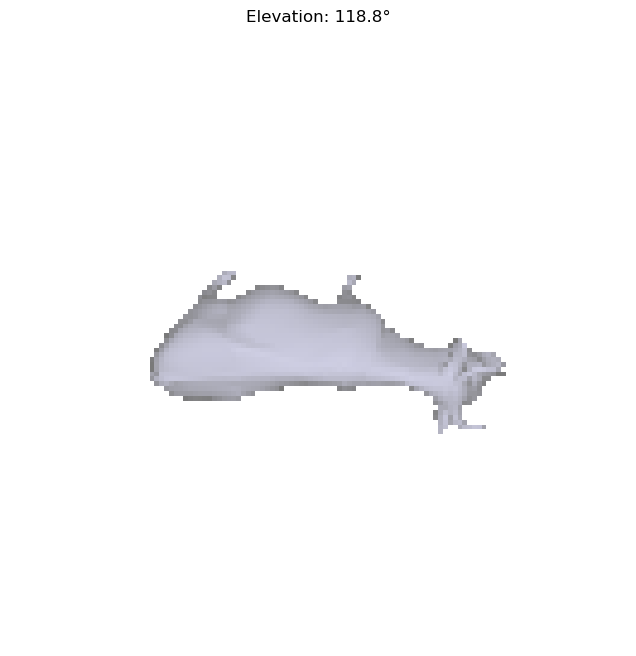

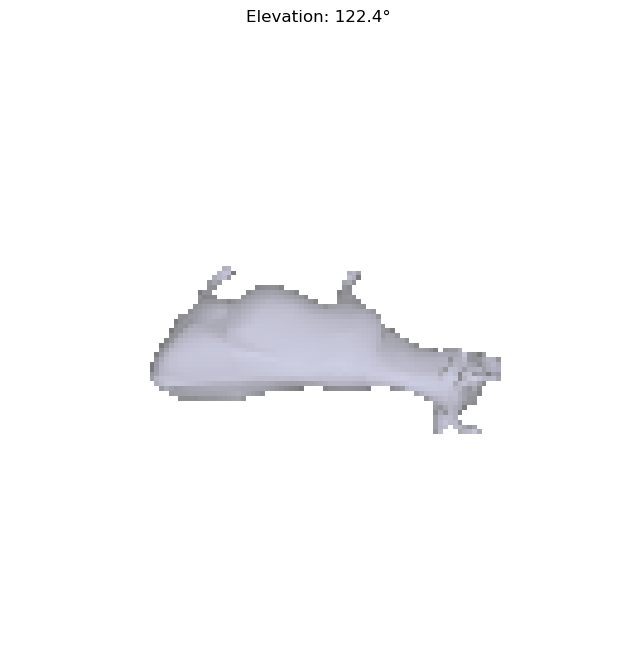

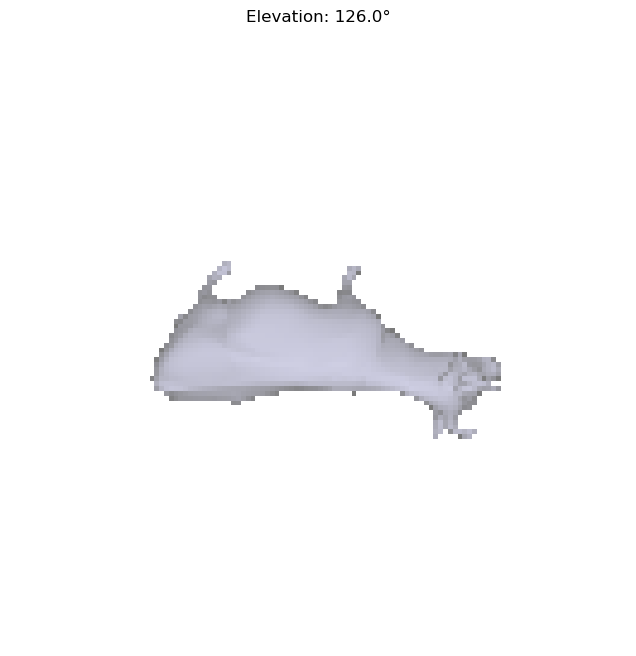

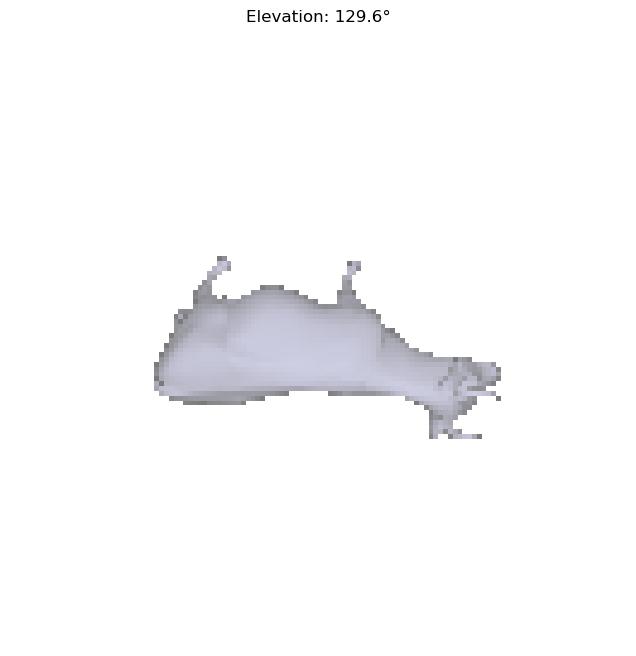

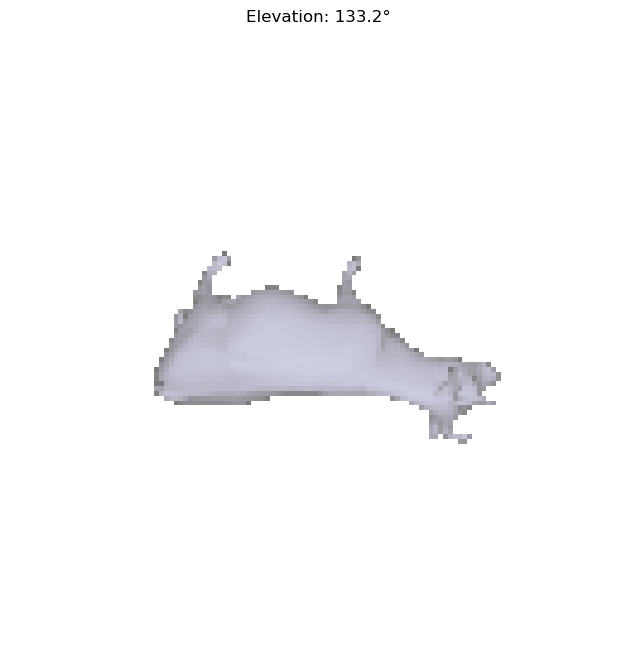

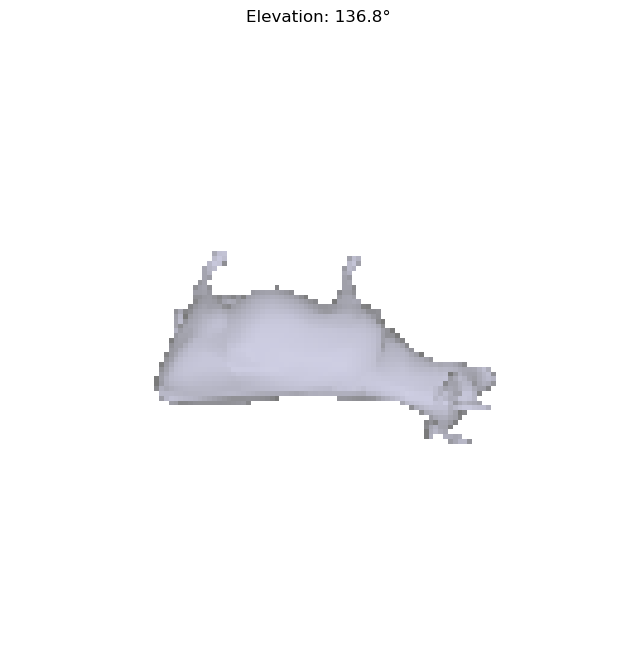

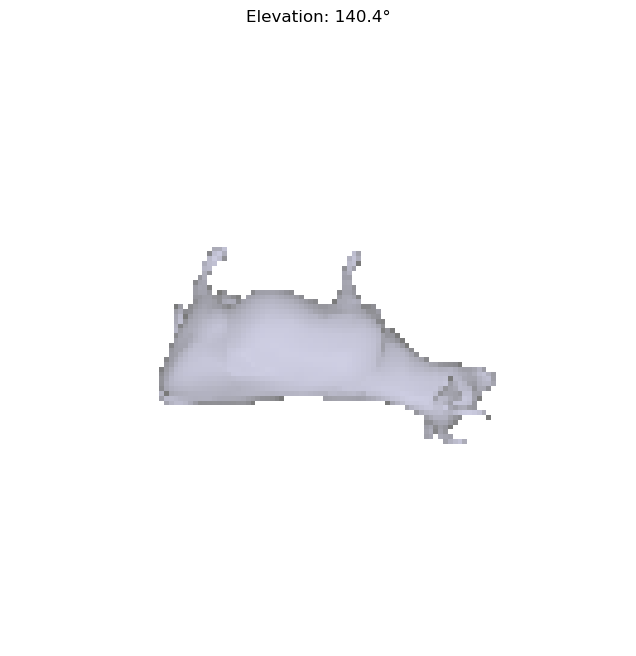

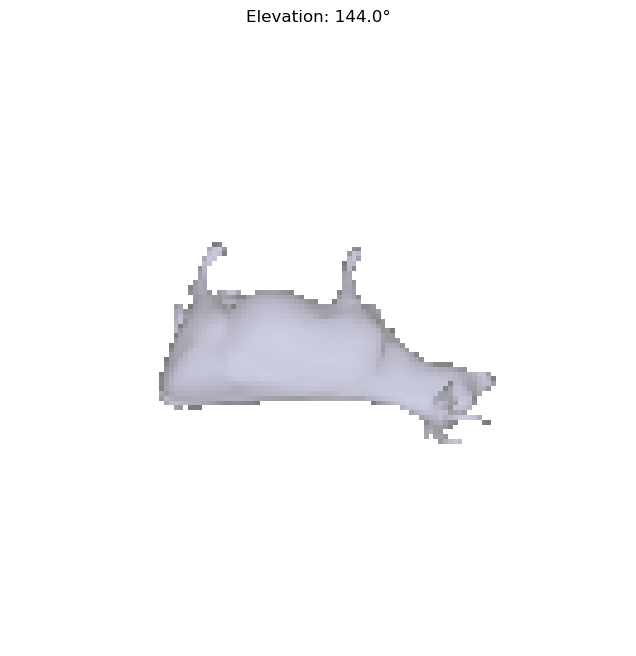

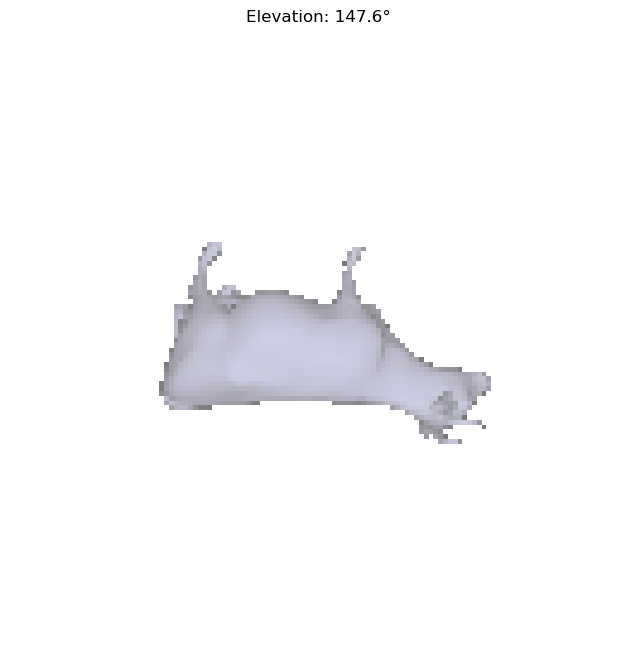

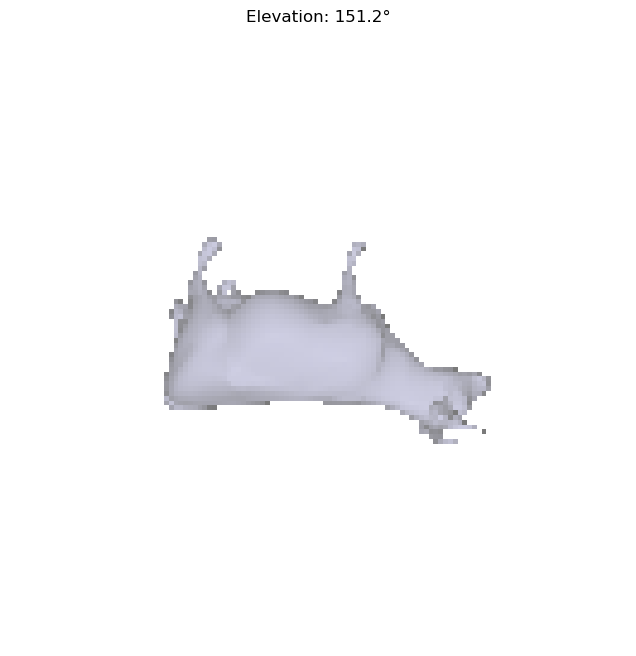

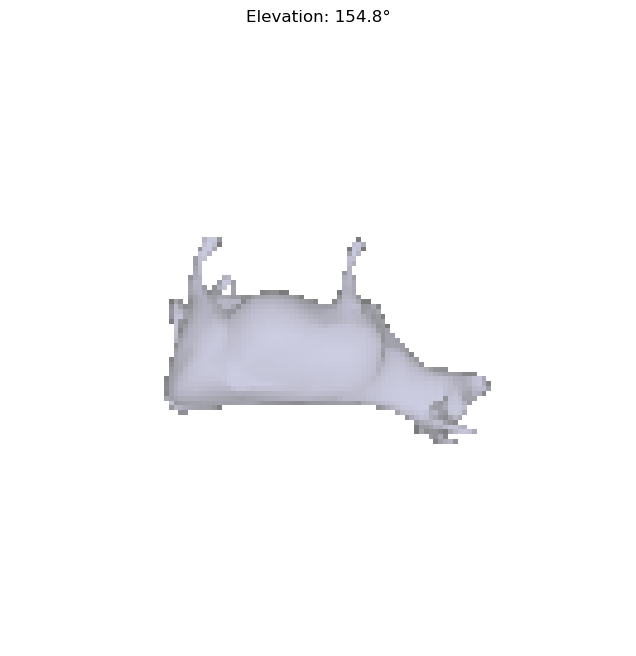

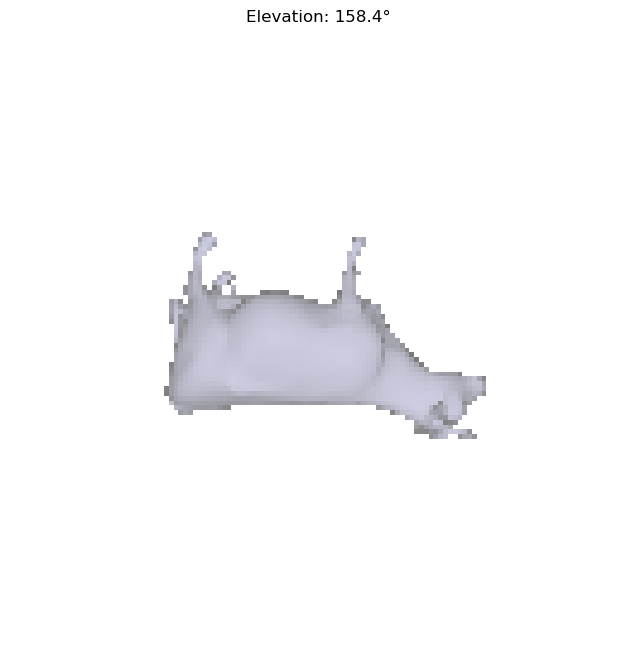

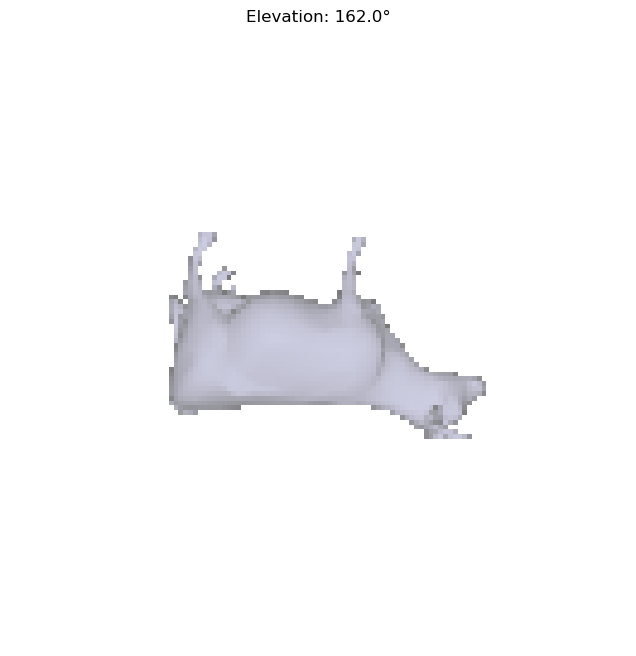

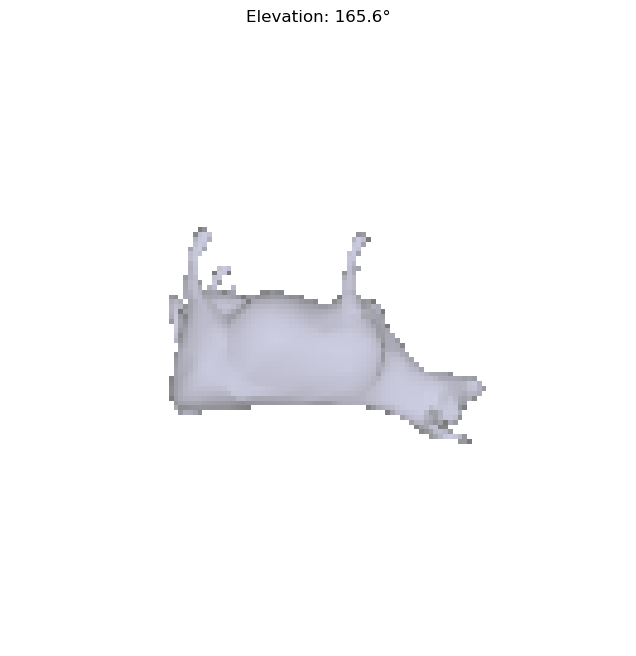

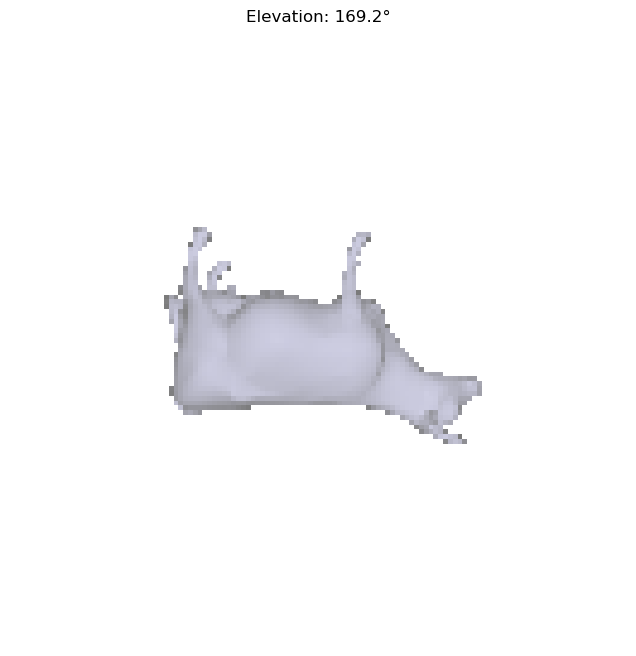

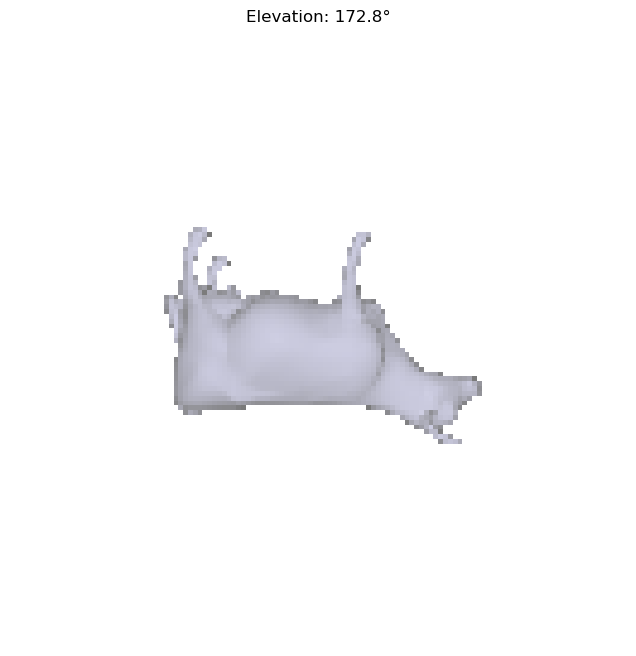

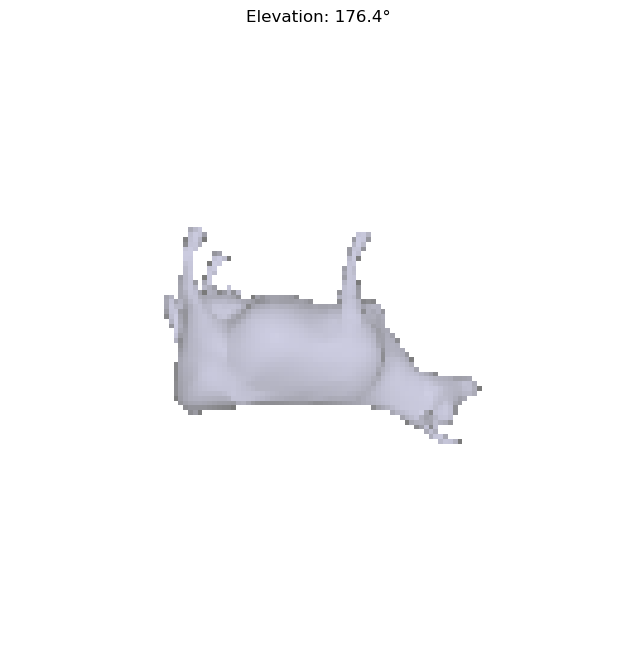

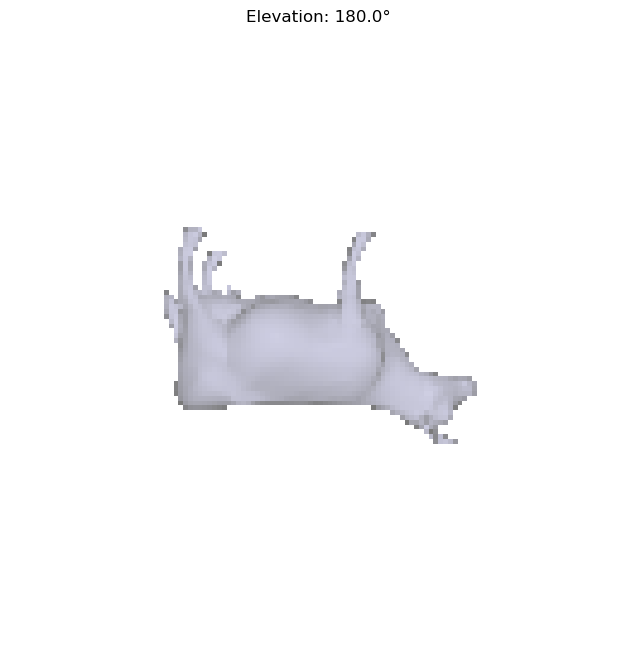

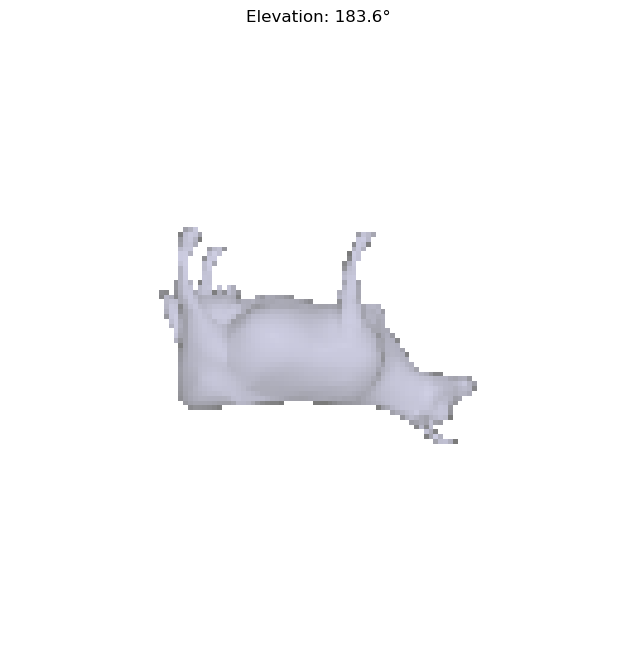

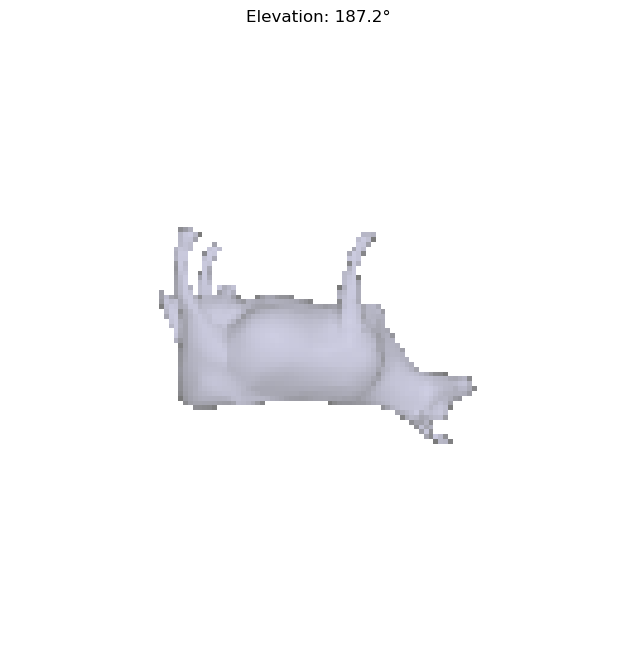

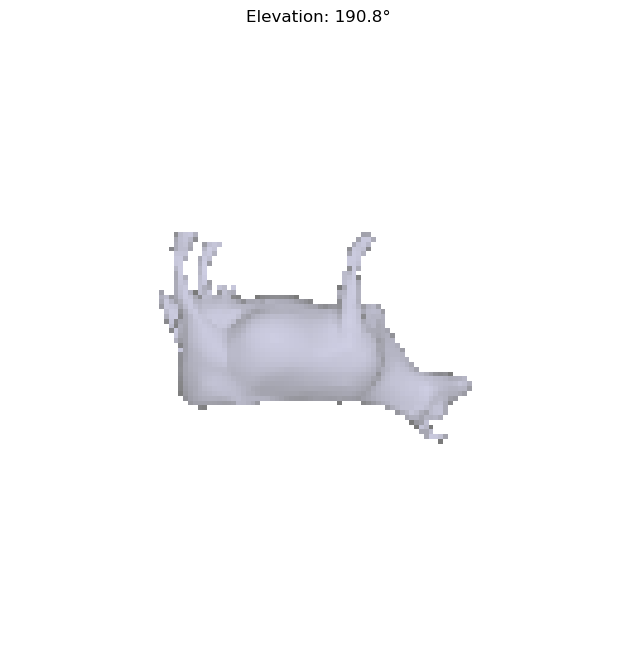

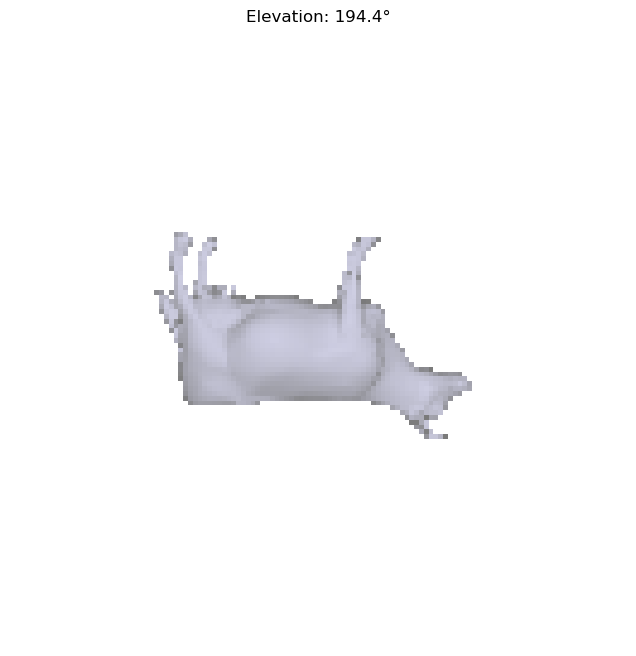

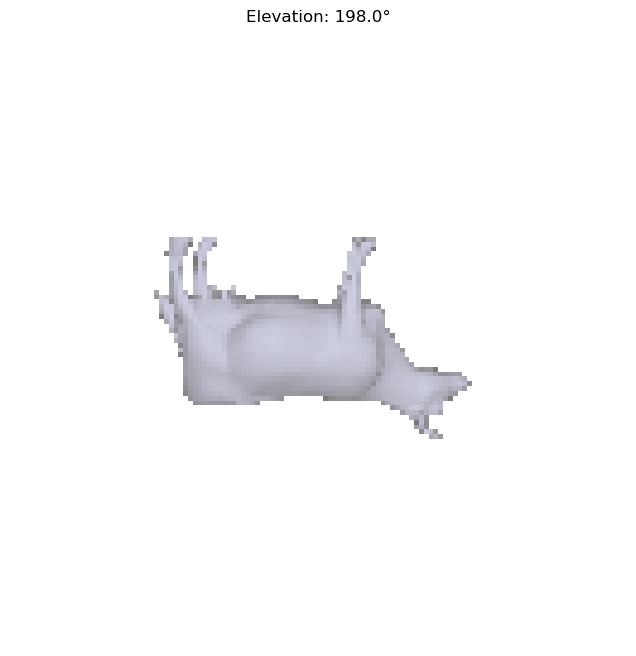

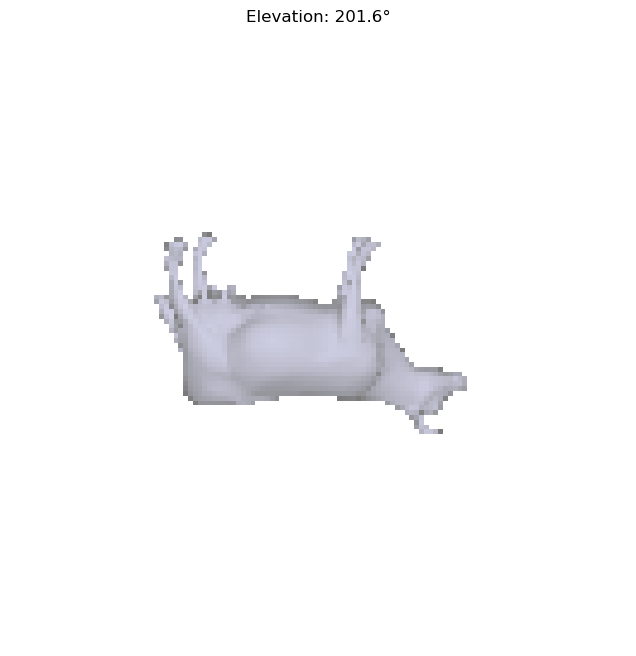

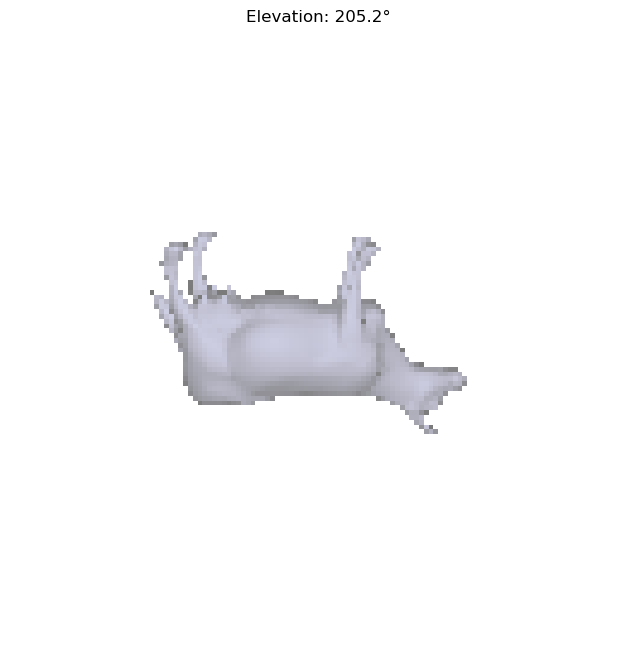

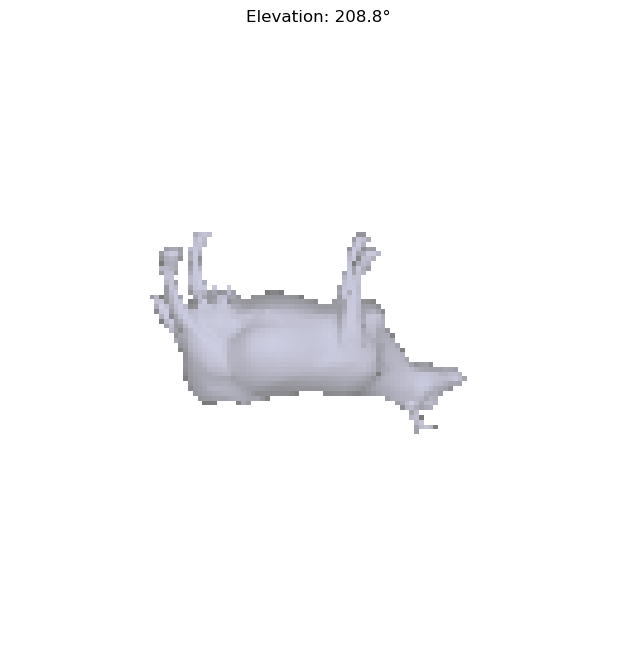

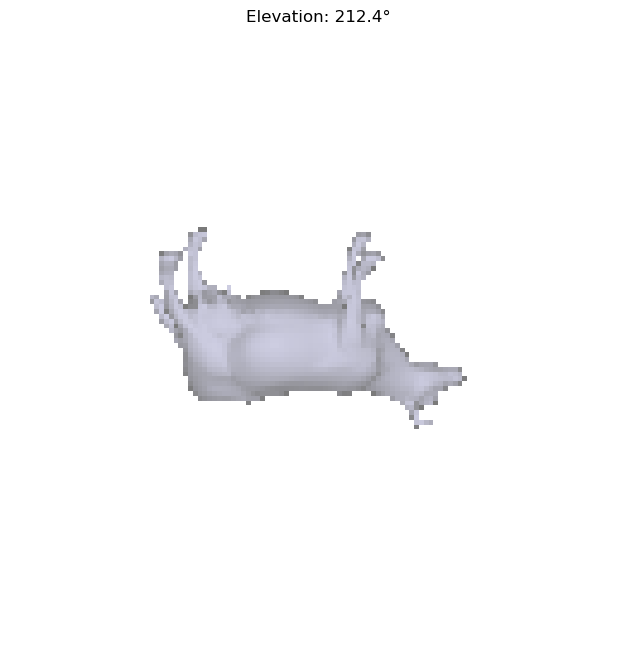

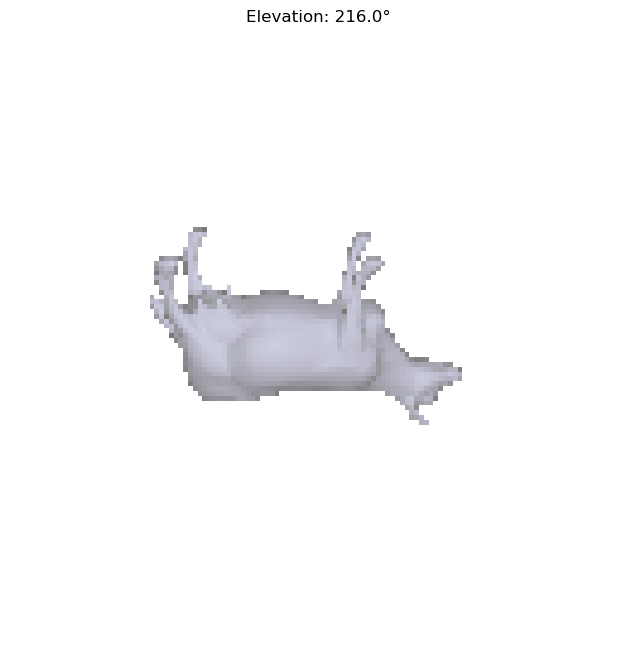

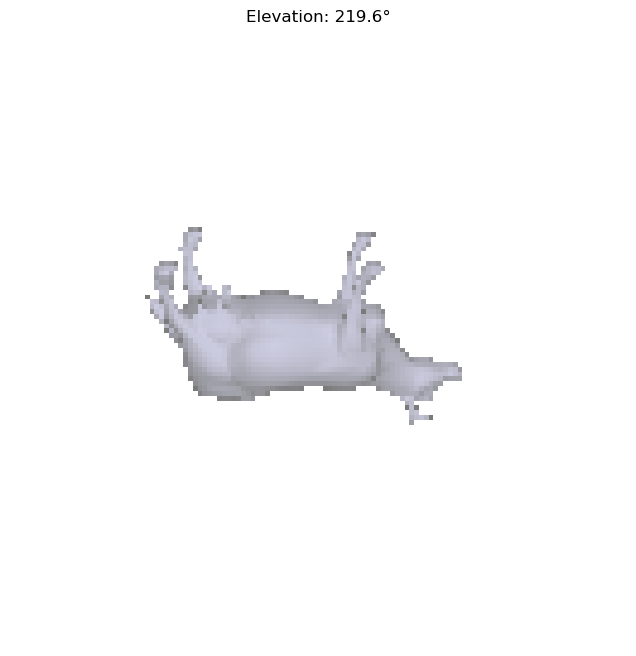

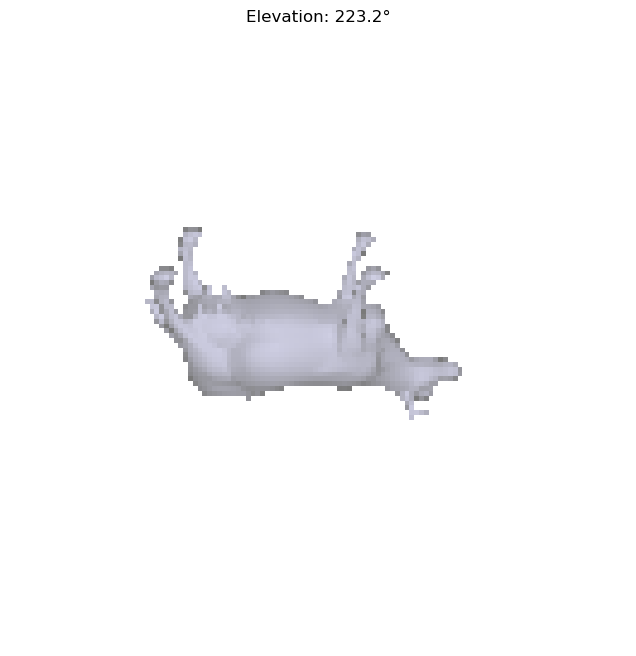

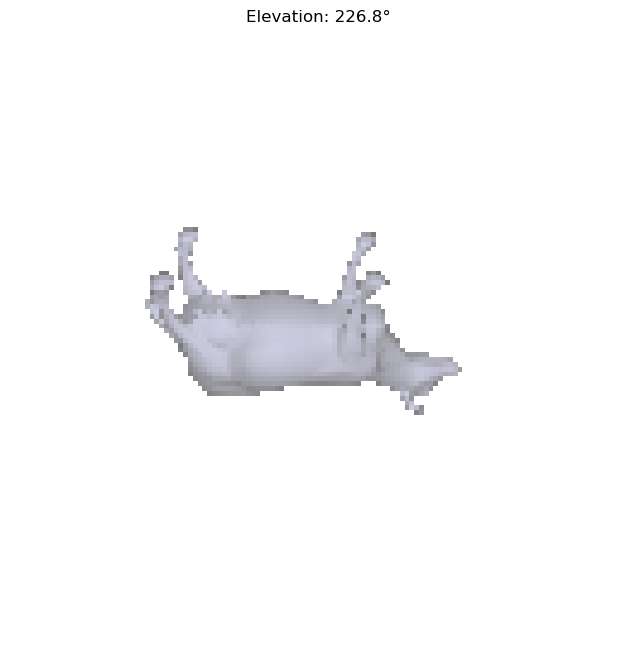

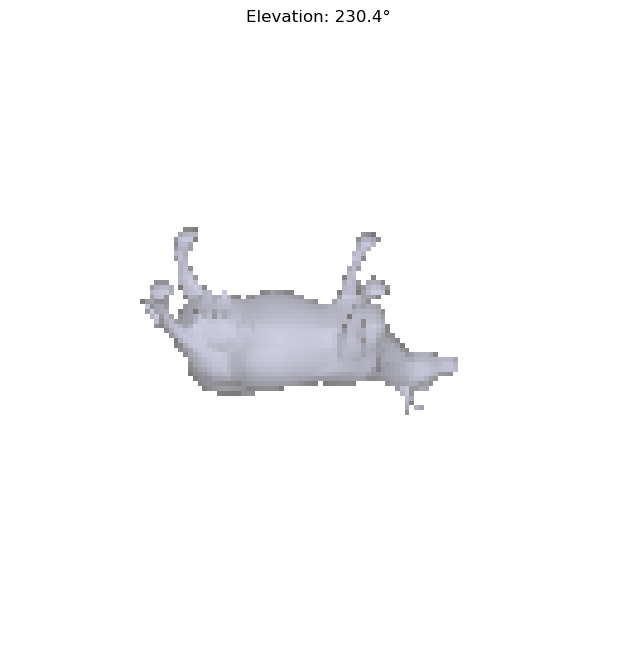

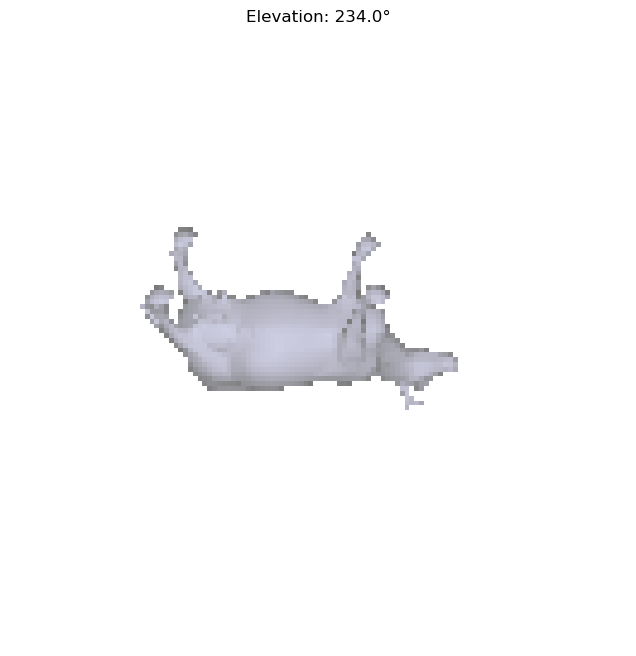

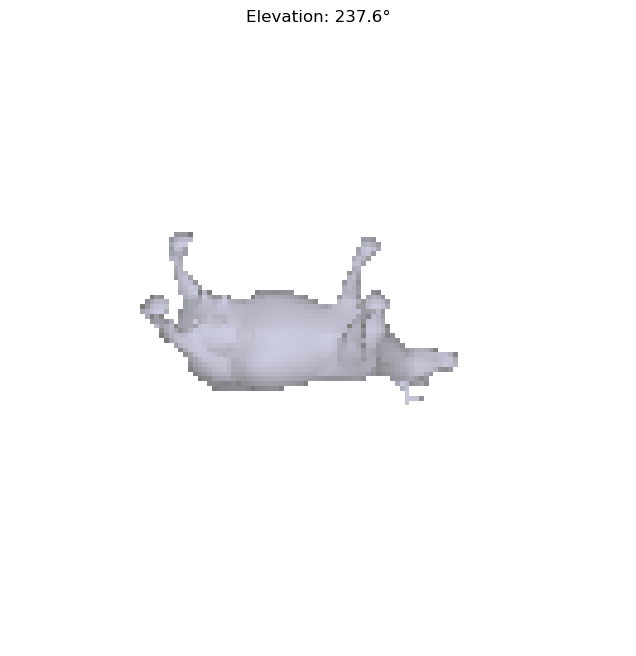

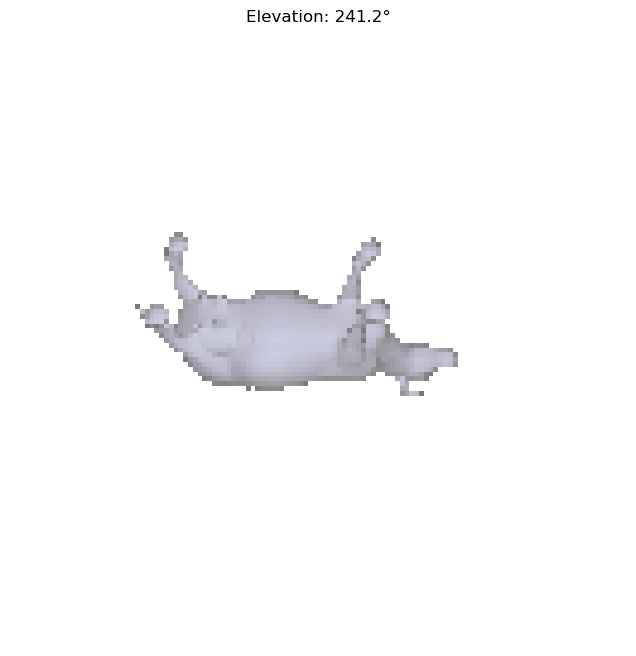

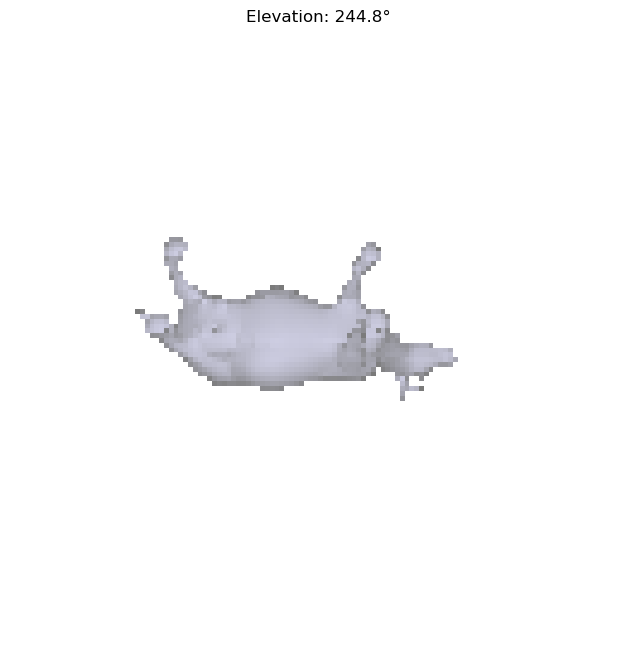

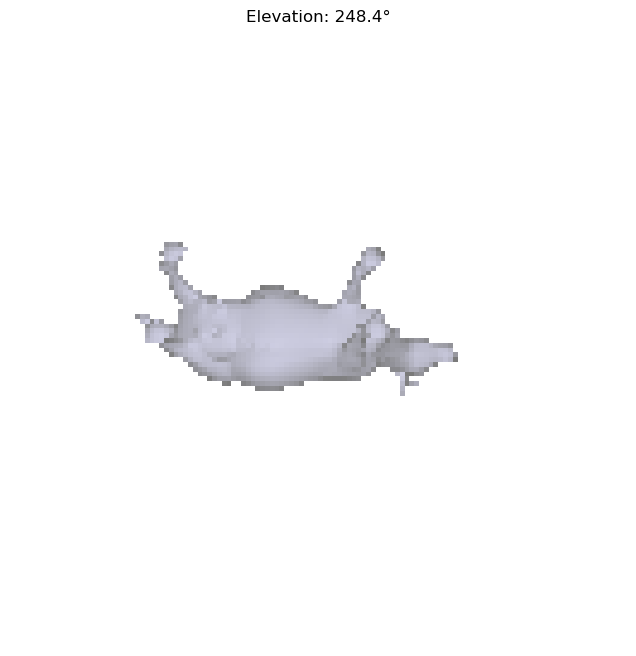

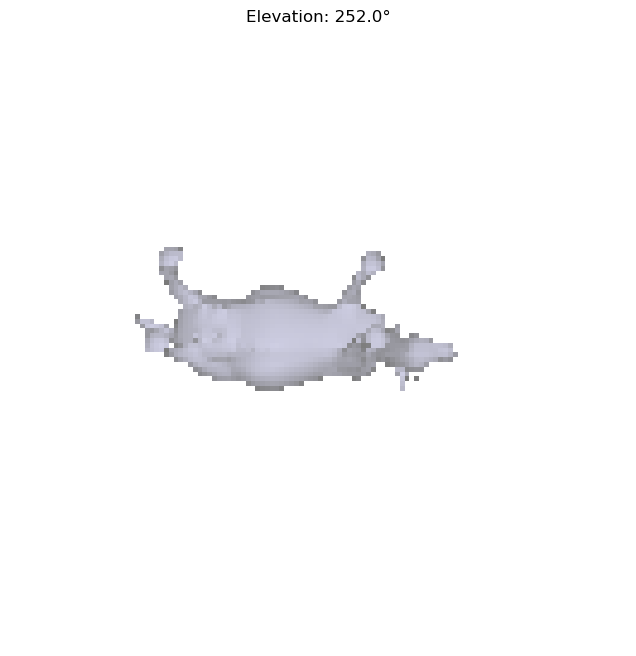

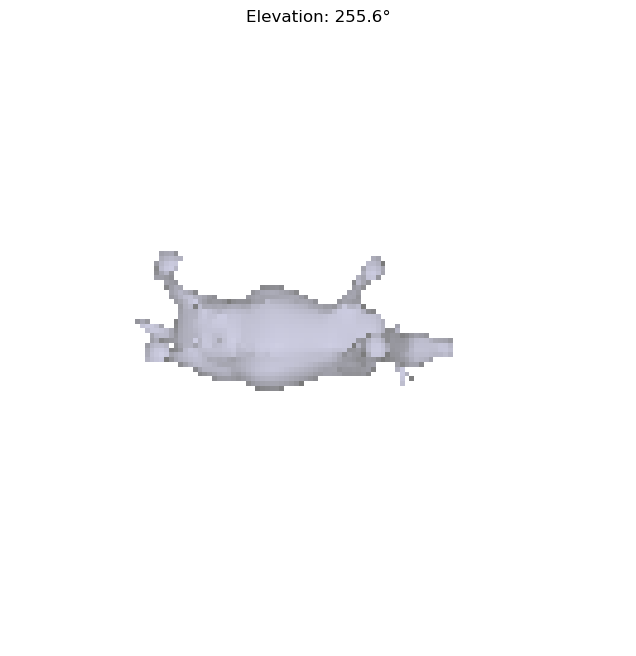

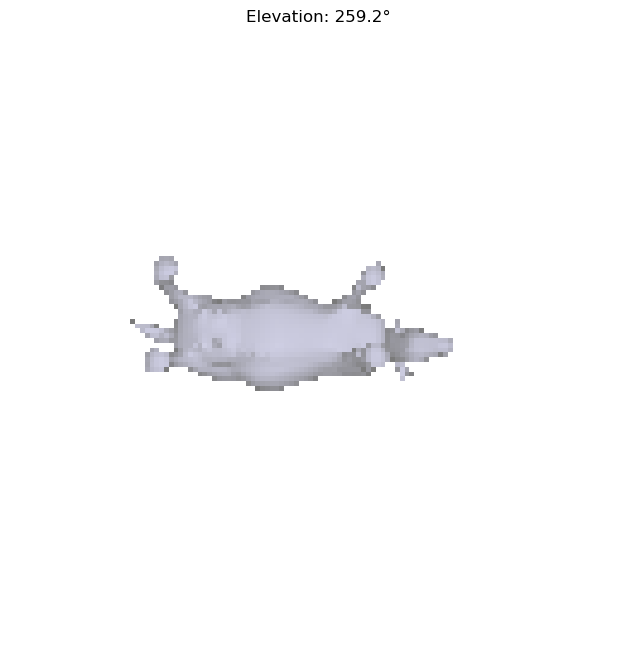

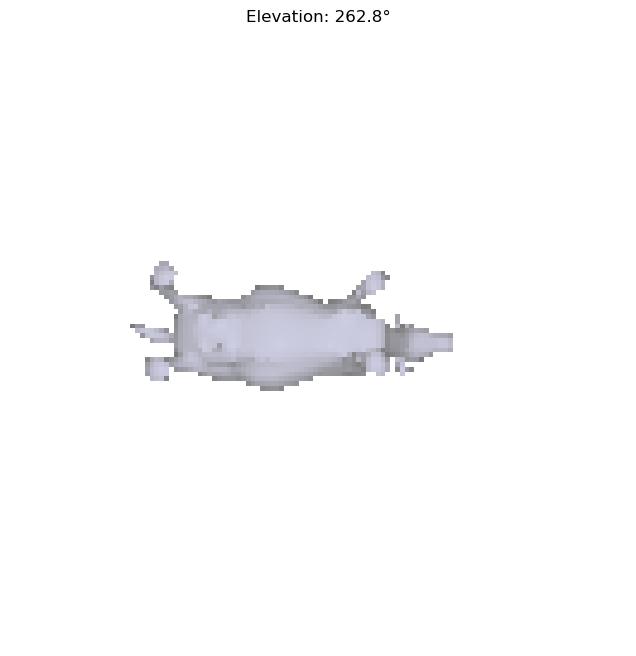

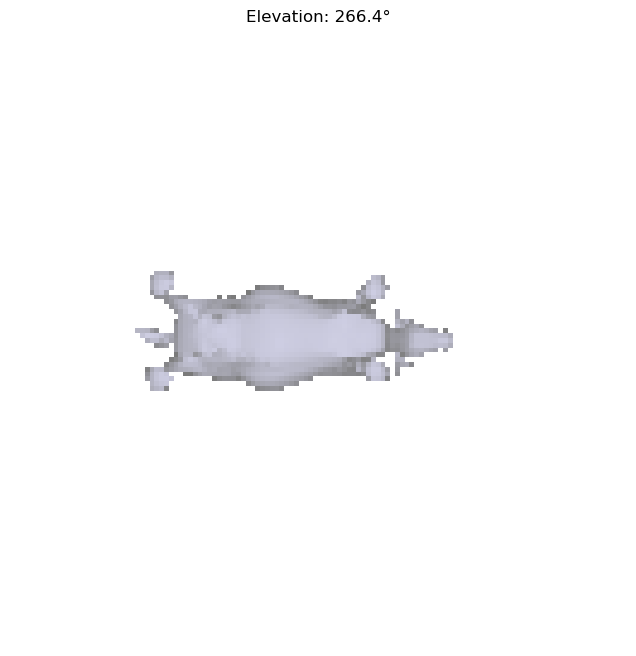

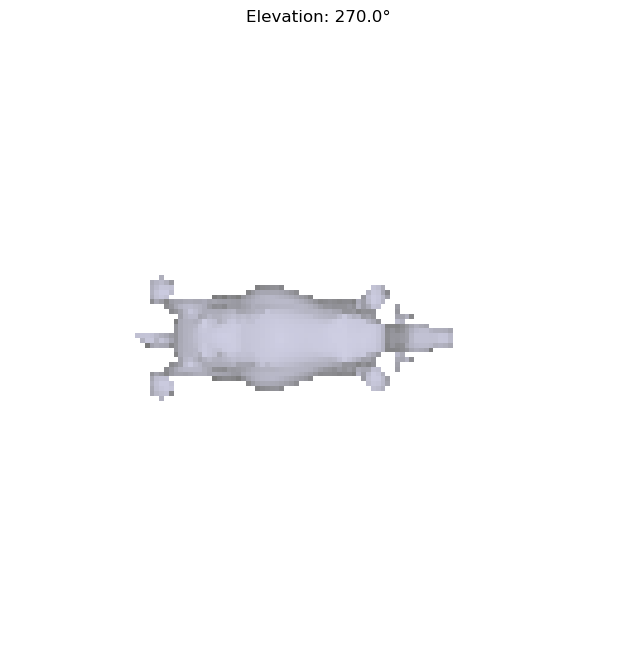

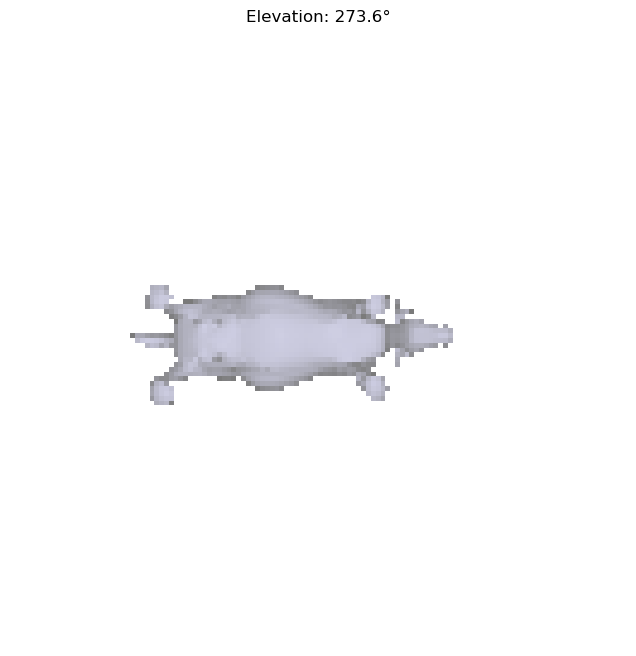

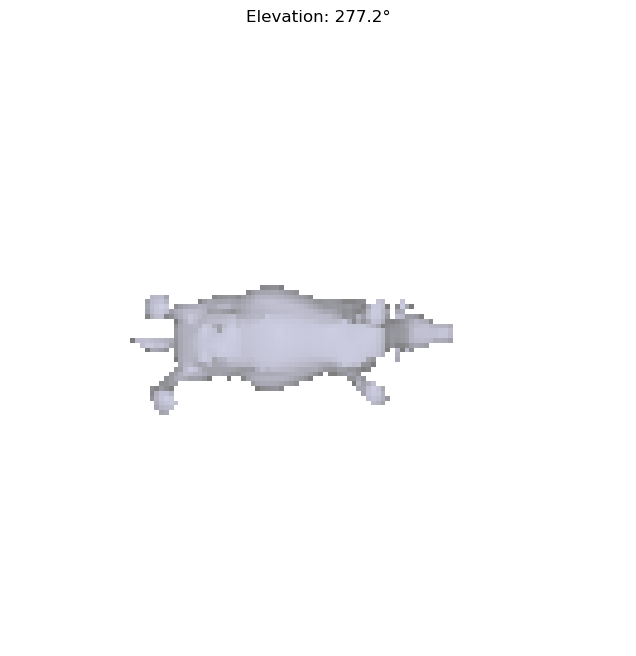

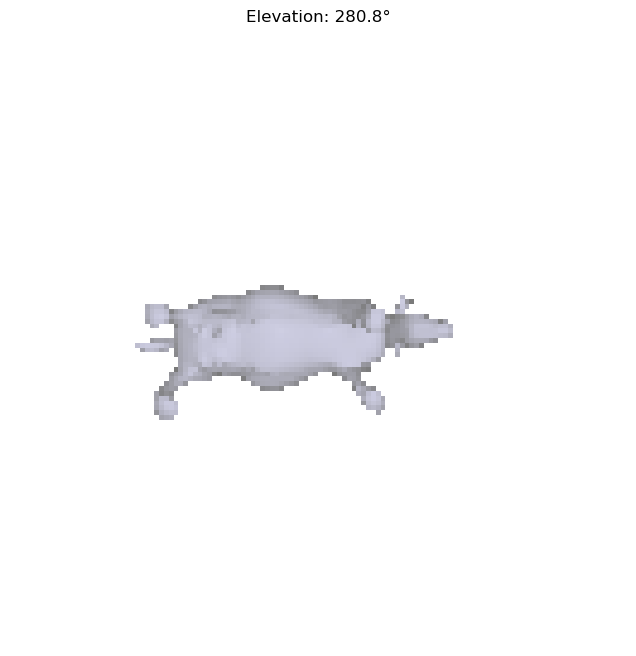

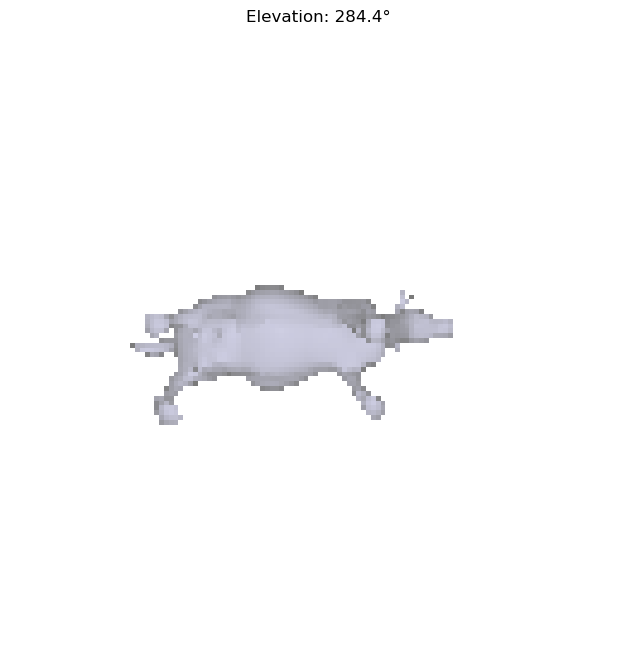

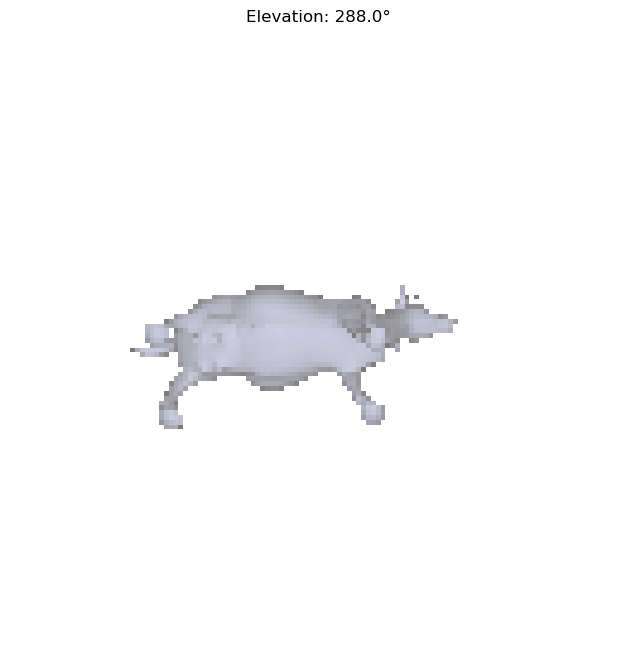

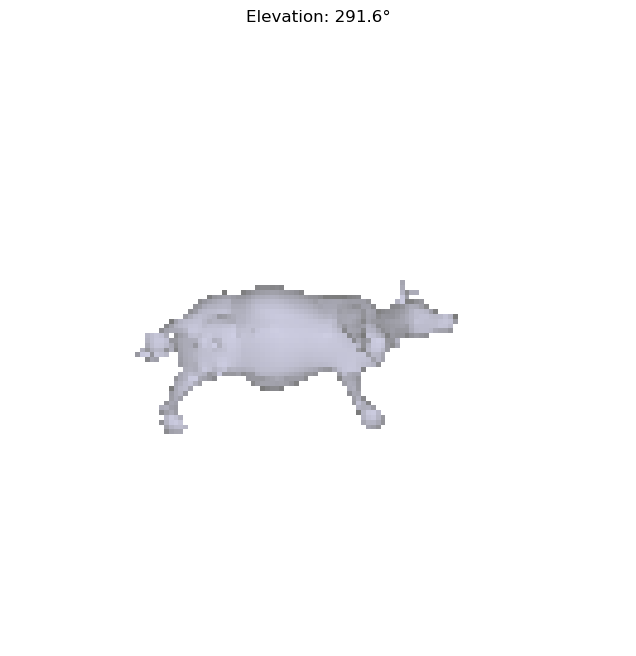

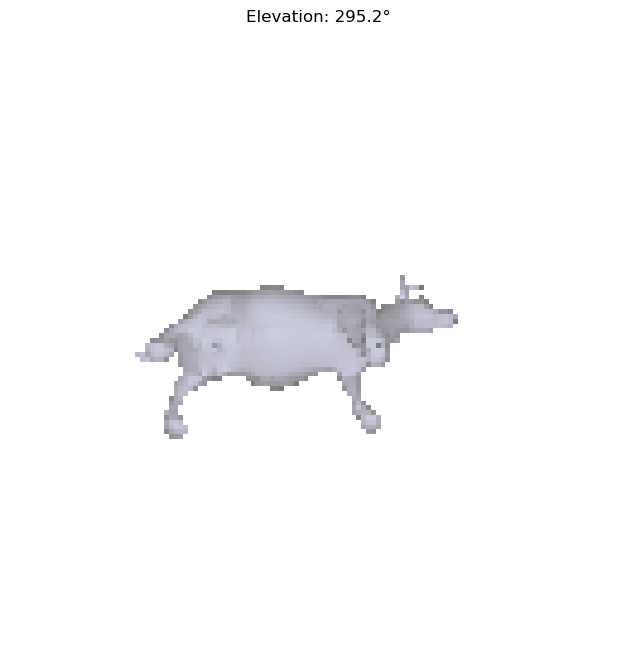

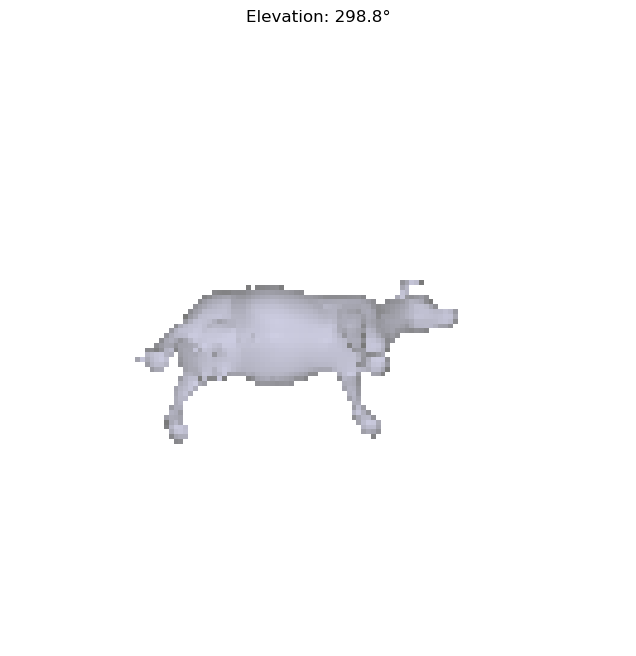

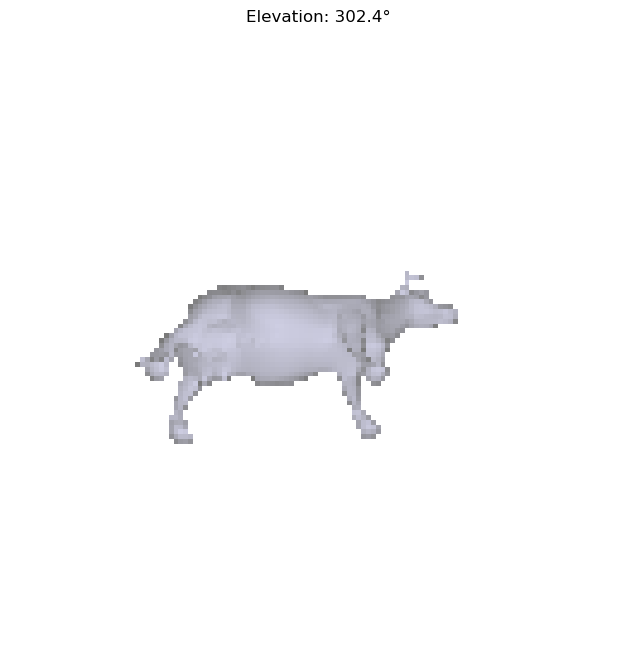

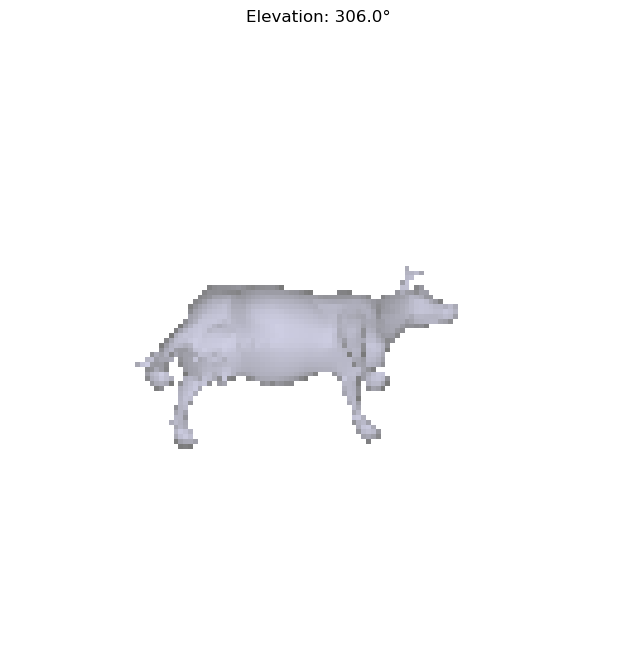

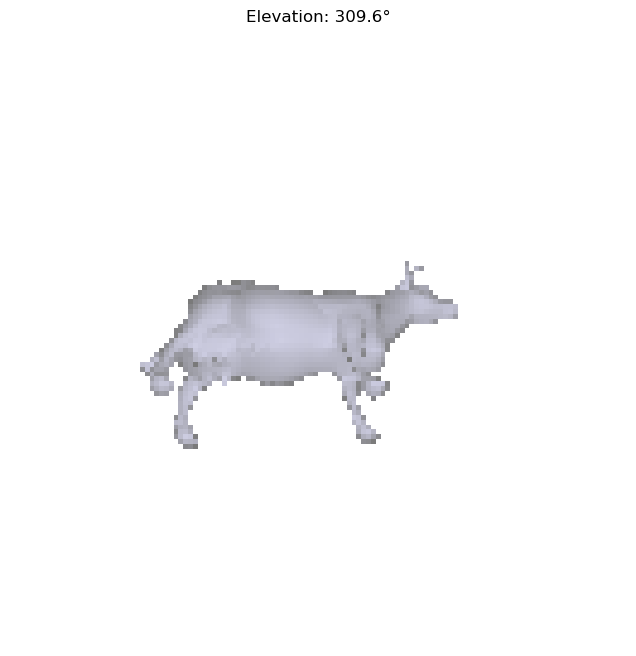

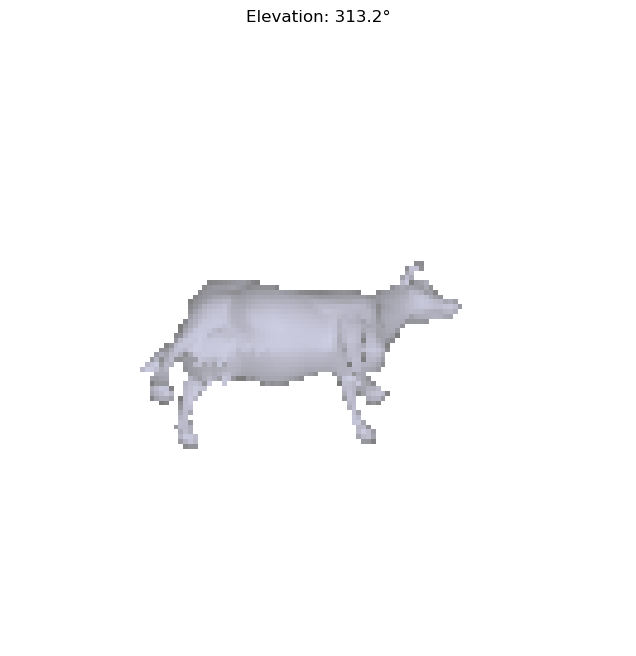

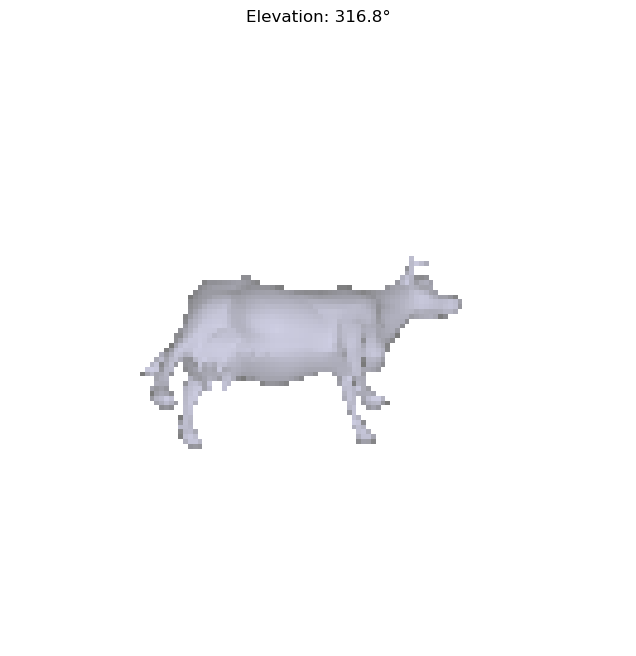

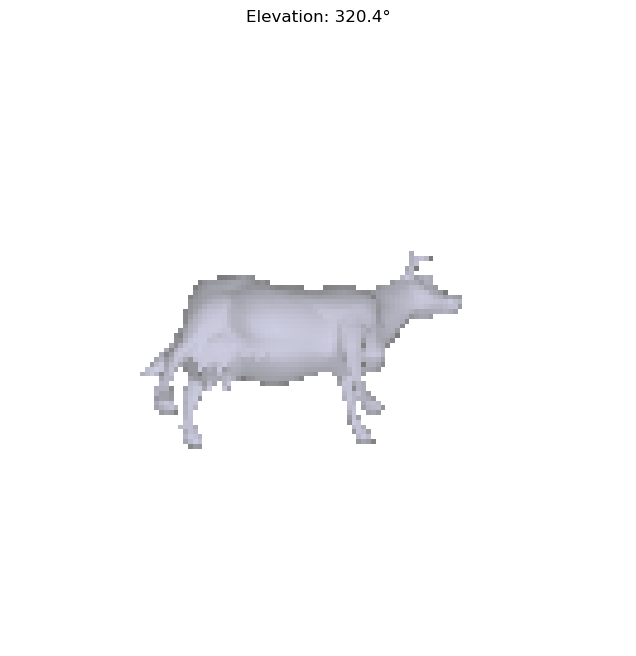

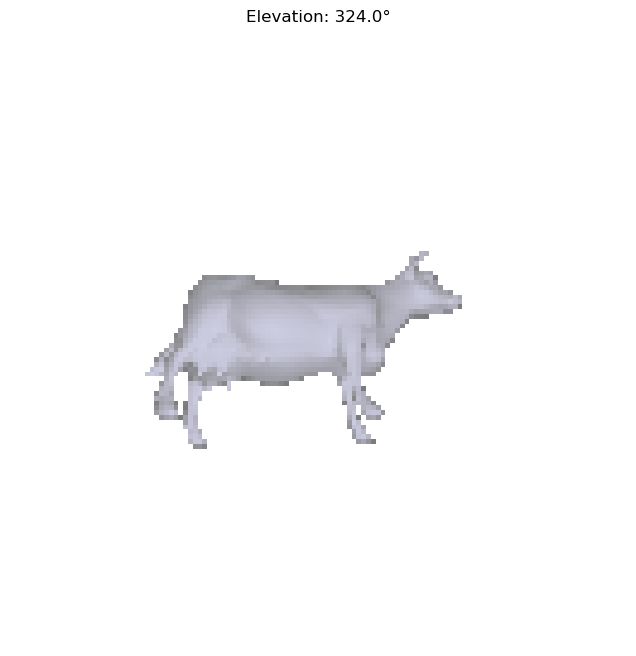

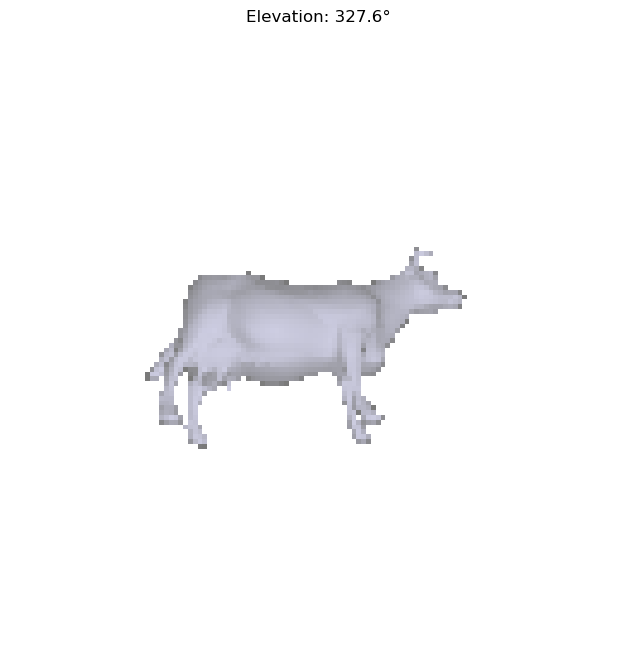

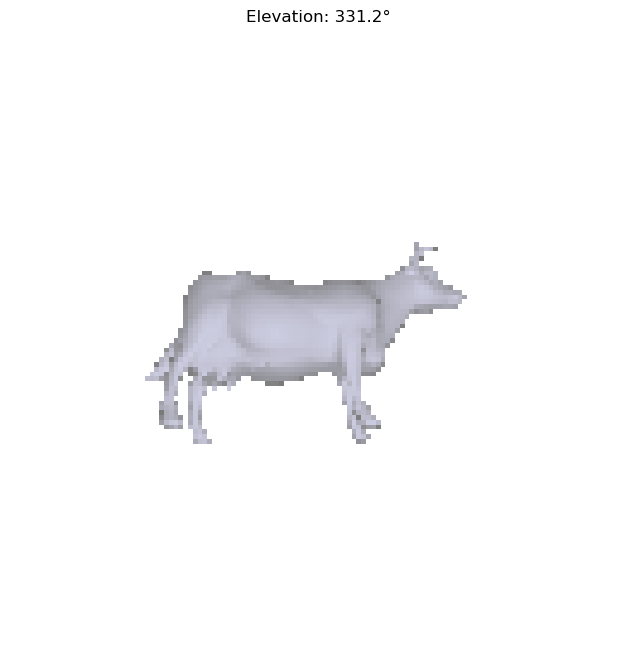

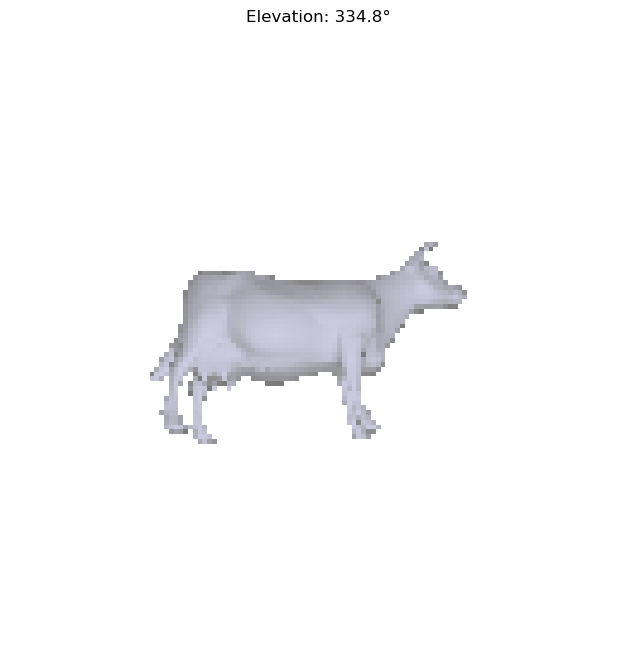

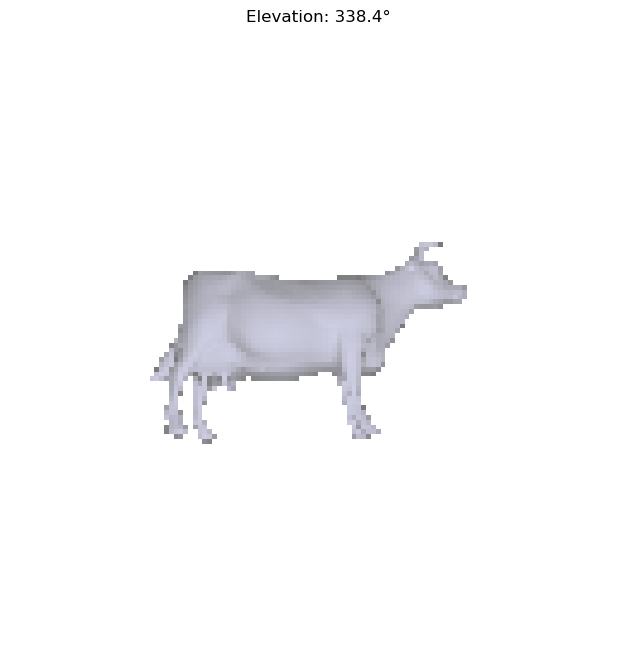

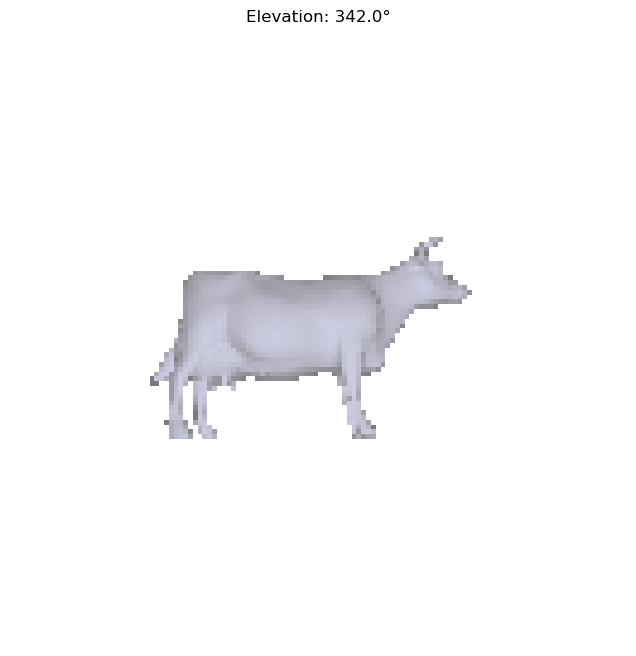

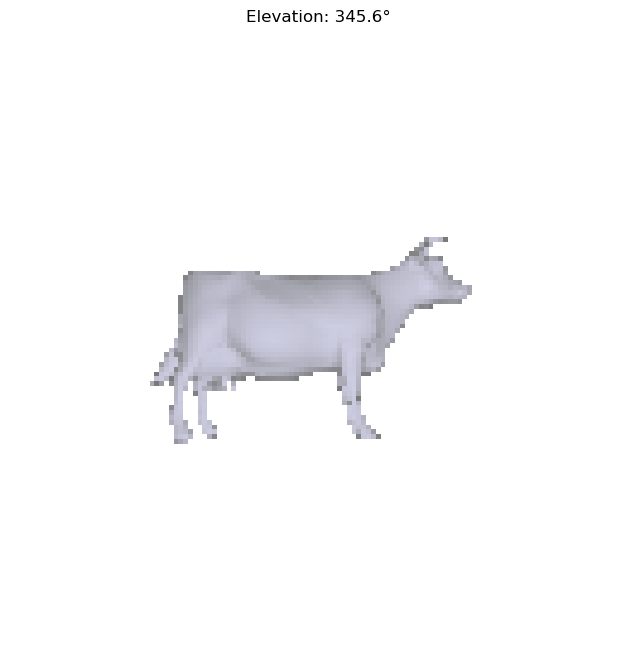

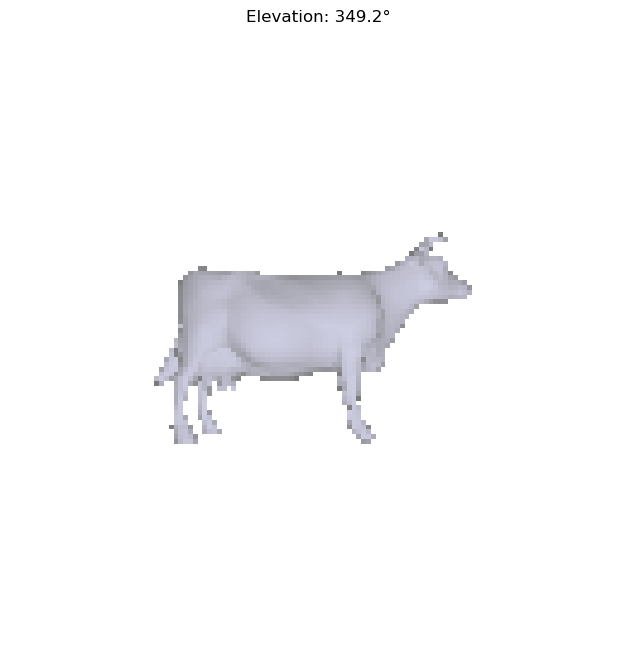

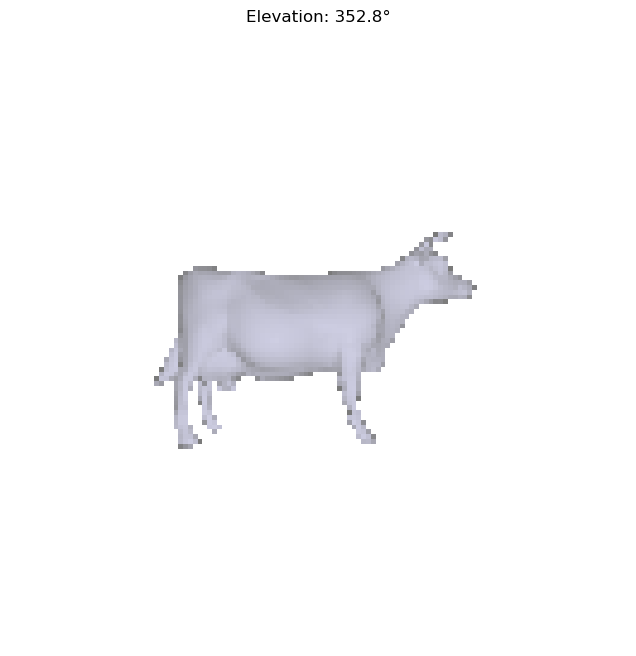

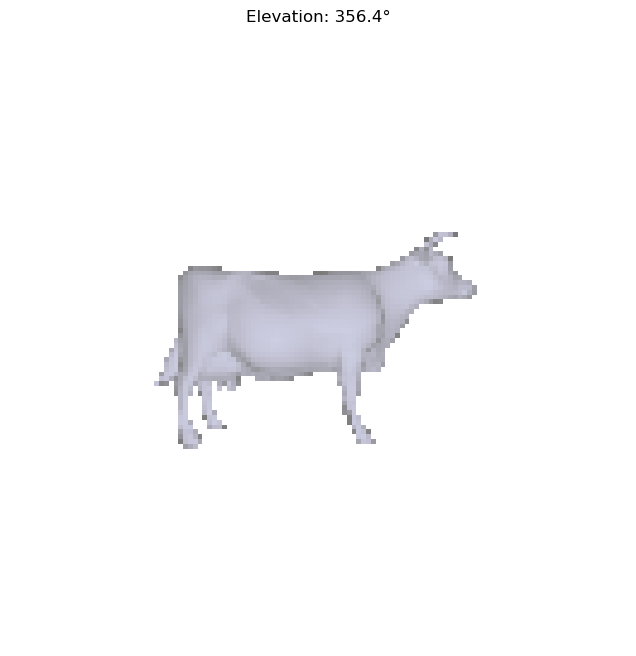

Video saved to rotation_video.mp4


In [15]:
# Use the visualization function
#combined_renderings = torch.cat([batched_renderings, batched_renderings_elev], axis=0)

# visualize_rotation_sequence(batched_renderings, num_views, save_video=True)
visualize_rotation_sequence(batched_renderings_elev, num_views, save_video=True)

import subprocess
import os

def play_video_mac(video_path):
    # Ensure the file exists
    if not os.path.exists(video_path):
        print(f"Error: File not found at {video_path}")
        return
    
    # Open video with the default application
    try:
        subprocess.run(["open", video_path], check=True)
    except subprocess.CalledProcessError as e:
        print(f"Error: {e}")

# Example usage
video_path = "rotation_video.mp4"
play_video_mac(video_path)

#visualize_rotation_sequence(combined_renderings, num_views*2, save_video=True)